# Evaluating Tikhonet Trained

In this Notebook we are going to evaluate the performance of a [Tikhonet](https://arxiv.org/pdf/1911.00443.pdf) trained.

## Required Libraries and Functions

In [1]:
%matplotlib inline
import sys
import numpy as np

# Directories and paths
lib_path = '/gpfswork/rech/xdy/uze68md/GitHub/'
data_path = '/gpfswork/rech/xdy/uze68md/data/'
model_dir = '/gpfswork/rech/xdy/uze68md/trained_models/model_meerkat_64/'

# Add library path to PYTHONPATH
path_alphatransform = lib_path+'alpha-transform'
path_score = lib_path+'score'
sys.path.insert(0, path_alphatransform)
sys.path.insert(0, path_score)

# Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import fft
import cadmos_lib as cl
import tensorflow as tf
import galsim
from galsim import Image
import galsim.hsm
import galflow as gf
from galaxy2galaxy import problems
import pickle

# set random seed
tf.random.set_random_seed(2)

# Functions

def ir2tf_simplifie(imp_resp, shape):
    

    dim = 2
    # Zero padding and fill
    irpadded = np.zeros(shape)
    irpadded[tuple([slice(0, s) for s in imp_resp.shape])] = imp_resp
    # Roll for zero convention of the fft to avoid the phase
    # problem. Work with odd and even size.
    for axis, axis_size in enumerate(imp_resp.shape):

        irpadded = np.roll(irpadded,
                           shift=-int(np.floor(axis_size / 2)),
                           axis=axis)

    return fft.rfftn(irpadded, axes=range(-dim, 0))

def laplacian_simplifie(shape):
    
    impr = np.zeros([3,3])
    for dim in range(2):
        idx = tuple([slice(1, 2)] * dim +
                    [slice(None)] +
                    [slice(1, 2)] * (1 - dim))
        impr[idx] = np.array([-1.0,
                              0.0,
                              -1.0]).reshape([-1 if i == dim else 1
                                              for i in range(2)])
    impr[(slice(1, 2), ) * 2] = 4.0
    return ir2tf_simplifie(impr, shape), impr

def laplacian_tf(shape):
    return tf.convert_to_tensor(laplacian_simplifie(shape)[0])

def wiener_tf(image, psf, balance, laplacian=True):
    r"""Applies Wiener filter to image.

    This function takes an image in the direct space and its corresponding PSF in the
    Fourier space and performs a deconvolution using the Wiener Filter.

    Parameters
    ----------
    image   : 2D TensorFlow tensor
        Image in the direct space.
    psf     : 2D TensorFlow tensor
        PSF in the Fourier space (or K space).
    balance : scalar
        Weight applied to regularization.
    laplacian : boolean
        If true the Laplacian regularization is used else the identity regularization 
        is used.

    Returns
    -------
    tuple
        The first element is the filtered image in the Fourier space.
        The second element is the PSF in the Fourier space (also know as the Transfer
        Function).
    """
    trans_func = psf
    if laplacian:
        reg = laplacian_tf(image.shape)
        if psf.shape != reg.shape:
            trans_func = tf.signal.rfft2d(tf.signal.ifftshift(tf.cast(psf, 'float32')))
        else:
            trans_func = psf
    
    arg1 = tf.cast(tf.math.conj(trans_func), 'complex64')
    arg2 = tf.dtypes.cast(tf.math.abs(trans_func),'complex64') ** 2
    arg3 = balance
    if laplacian:
        arg3 *= tf.dtypes.cast(tf.math.abs(laplacian_tf(image.shape)), 'complex64')**2
    wiener_filter = arg1 / (arg2 + arg3)
    
    # Apply wiener in Foutier (or K) space
    wiener_applied = wiener_filter * tf.signal.rfft2d(tf.cast(image, 'float32'))
    
    return wiener_applied, trans_func

def pre_proc_unet(dico):
    r"""Preprocess the data and apply the Tikhonov filter on the input galaxy images.

    This function takes the dictionnary of galaxy images and PSF for the input and
    the target and returns a list containing 2 arrays: an array of galaxy images that
    are the output of the Tikhonov filter and an array of target galaxy images.

    Parameters
    ----------
    dico : dictionnary
        Array_like means all those objects -- lists, nested lists, etc. --
        that can be converted to an array.  We can also refer to
        variables like `var1`.

    Returns
    -------
    list
        list containing 2 arrays: an array of galaxy images that are the output of the
        Tikhonov filter and an array of target galaxy images.

    Example
    -------
    These are written in doctest format, and should illustrate how to
    use the function.

    >>> from galaxy2galaxy import problems # to list avaible problems run problems.available()
    >>> problem128 = problems.problem('attrs2img_cosmos_hst2euclide')
    >>> dset = problem128.dataset(Modes.TRAIN, data_dir='attrs2img_cosmos_hst2euclide')
    >>> dset = dset.map(pre_proc_unet)
    """
    # First, we interpolate the image on a finer grid
    x_interpolant=tf.image.ResizeMethod.BICUBIC
    interp_factor = 2
    Nx = 128
    Ny = 128
    
    dico['inputs'] = tf.image.resize(dico['targets'],
                                  [Nx*interp_factor, Ny*interp_factor],
                                  method=x_interpolant)
    
    # Second, we add noise
    sigma = 7e-4
    noise = tf.random_normal(shape=tf.shape(dico['inputs']), mean=0.0, stddev=sigma, dtype=tf.float32)
    dico['inputs'] = dico['inputs'] + noise
    dico['psf'] = tf.cast(dico['psf'][...,0]/tf.math.reduce_max(dico['psf'][...,0]), dtype=tf.complex64)
    dico['mask'] = tf.identity(dico['psf'])
    dico['inputs'] = tf.signal.rfft2d(dico['inputs'][...,0])
    dico['inputs'] = tf.expand_dims(dico['inputs'], axis=0)
    dico['psf'] = tf.expand_dims(dico['psf'], axis=0)
    dico['inputs'] = gf.kconvolve(dico['inputs'], dico['psf'],
                   interp_factor=interp_factor)[0]
    dico['psf'] = tf.signal.ifftshift(tf.signal.irfft2d(dico['psf'], fft_length=[2*Nx,2*Ny]))
    
    # Third, we normalize the Unet inputs to improve the training
    norm_factor = 5e2
    dico['inputs'] = dico['inputs']*norm_factor
    dico['targets'] = dico['targets']*norm_factor

    # Fourth, we compute the Tikhonet solution for the input
    # Since we lower the resolution of the image, we also scale the flux
    # accordingly
    dico['inputs'] = tf.image.resize(dico['inputs'],
                                  [Nx*interp_factor, Ny*interp_factor],
                                  method=x_interpolant)
    dico['inputs'] = dico['inputs'] / interp_factor**2
    
    # Fifth, we scale the tikhonet solutions back to the initial size
    balance = 1e-2
    dico['inputs_tikho'], _ = wiener_tf(dico['inputs'][...,0], dico['mask'], balance)
    dico['inputs_tikho'] = tf.expand_dims(tf.signal.irfft2d(dico['inputs_tikho']), axis=-1)
    dico['inputs_tikho'] = tf.image.resize(dico['inputs_tikho'],
                                  [Nx, Ny],
                                  method=x_interpolant)
    dico['inputs_tikho'] = tf.image.central_crop(dico['inputs_tikho'], 0.5)
    dico['targets'] = tf.image.central_crop(dico['targets'], 0.5)
    
    return dico

## Generate The Evaluation Dataset

In [2]:
# Let's create an instance of the hsc_problem
Modes = tf.estimator.ModeKeys
problem128 = problems.problem('meerkat_3600')
dset = problem128.dataset(Modes.EVAL, data_dir=data_path+'meerkat_3600')
dset = dset.repeat()
dset = dset.map(pre_proc_unet)

n_batch = 128

dset = dset.batch(n_batch)


INFO:tensorflow:Reading data files from /gpfswork/rech/xdy/uze68md/data/meerkat_3600/meerkat_3600-dev*
INFO:tensorflow:partition: 0 num_data_files: 2

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Seed 2 from outer graph might be getting used by function Dataset_map_pre_proc_unet, if the random op has not been provided any seed. Explicitly set the seed in the function if this is not the intended behavior.
  


## Extract Batches and Concatenate Them

In [3]:
# Build an iterator over the dataset
iterator = dset.make_one_shot_iterator().get_next()
sess = tf.Session()

# Initialize batch
batch = sess.run(iterator)
k_batch = 16 #24

for k in range(k_batch-1):
    # Extract temporary batch
    tmp = sess.run(iterator)
    # Add to batch
    for key in tmp:
        batch[key]=np.concatenate((batch[key],tmp[key]))
sess.close()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [4]:
batch.keys()

dict_keys(['DEC', 'HAstart', 'e1', 'e2', 'flux', 'index', 'psf', 'targets', 'inputs', 'mask', 'inputs_tikho'])

## Plot Galaxy Images

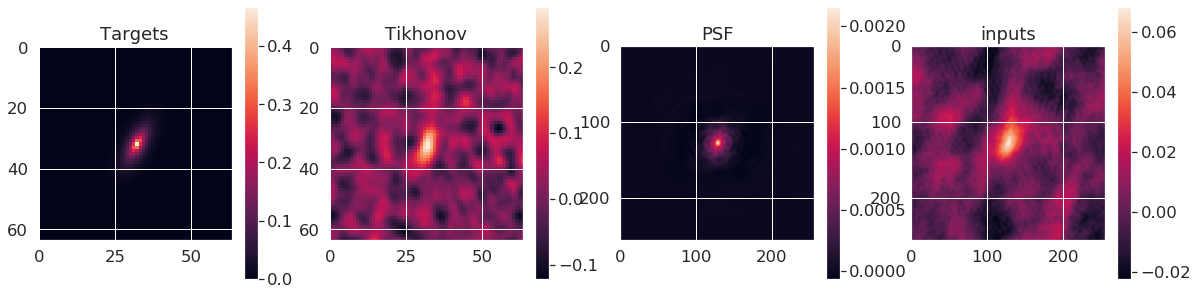

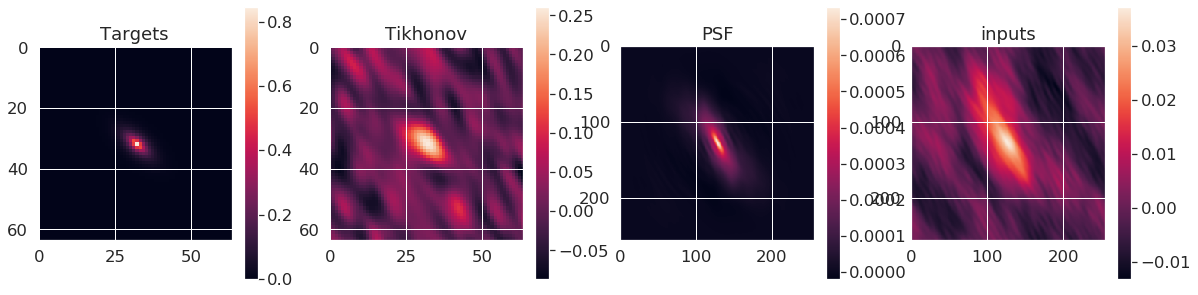

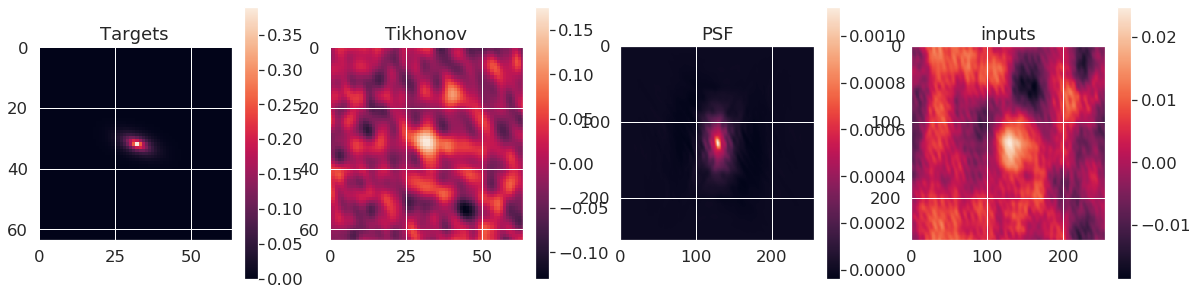

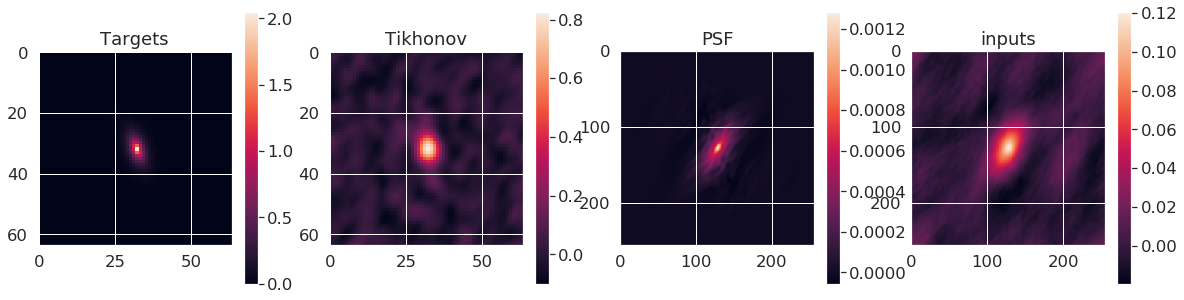

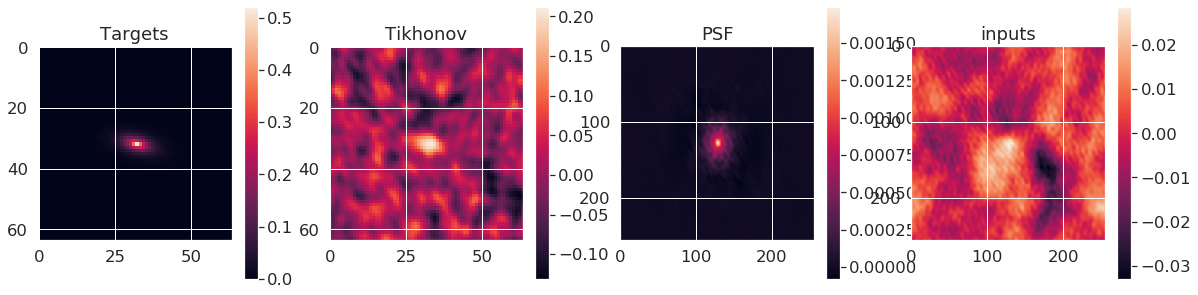

In [5]:
# set seaborn theme and style
sns.set_theme()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

for i in range(5):#n_batch):
    plt.figure(33,figsize=(20,5))
    plt.subplot(141)
    plt.imshow(batch['targets'][i,...,0])
    plt.title('Targets')
    plt.colorbar()
    plt.subplot(142)
    plt.imshow(batch['inputs_tikho'][i,...,0])
    plt.title('Tikhonov')
    plt.colorbar()
    plt.subplot(143)
    plt.imshow(batch['psf'][i,0])
    plt.title('PSF')
    plt.colorbar()
    plt.subplot(144)
    plt.imshow(batch['inputs'][i,...,0])
    plt.title('inputs')
    plt.colorbar()
    plt.show()

## Load and Apply Trained Model on Batch

In [6]:
model_name_g0 = 'tikhonet_None-constraint_scales-4_steps-3125_epochs-10_growth_rate-12_batch_size-32_activationfunction-relu'
model_name_g05 = 'tikhonet_multi-constraint_scales-4_gamma-0.5_shearlet-3_steps-3125_epochs-10_growth_rate-12_batch_size-32_activationfunction-relu'

model_g0 = tf.keras.models.load_model(model_dir+model_name_g0, compile=False)
model_g05 = tf.keras.models.load_model(model_dir+model_name_g05, compile=False)

res_g0 = model_g0(batch['inputs_tikho'])
res_g05 = model_g05(batch['inputs_tikho'])

res_g0 = tf.keras.backend.eval(res_g0)[...,0]
res_g05 = tf.keras.backend.eval(res_g05)[...,0]

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
for key in ['inputs', 'inputs_tikho', 'targets']:
    batch[key] = batch[key][...,0]

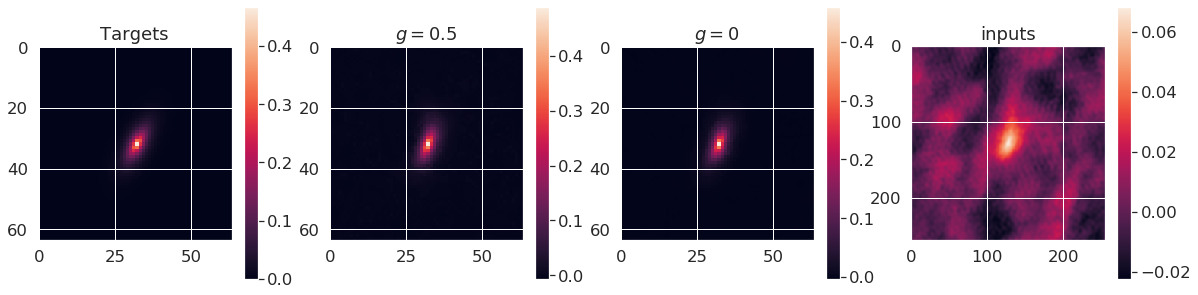

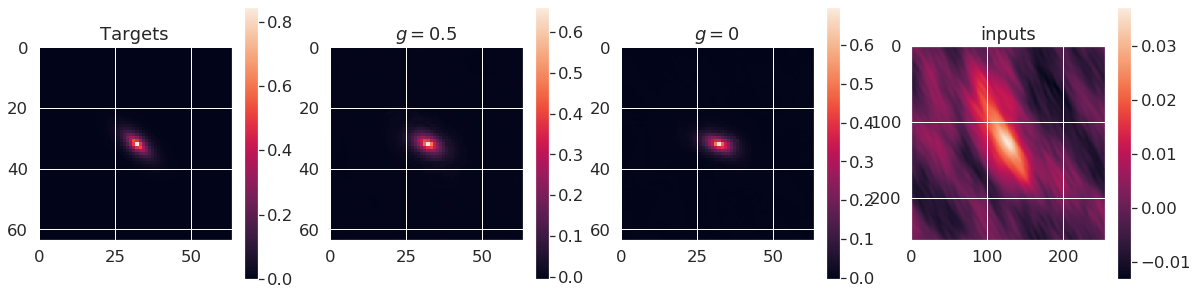

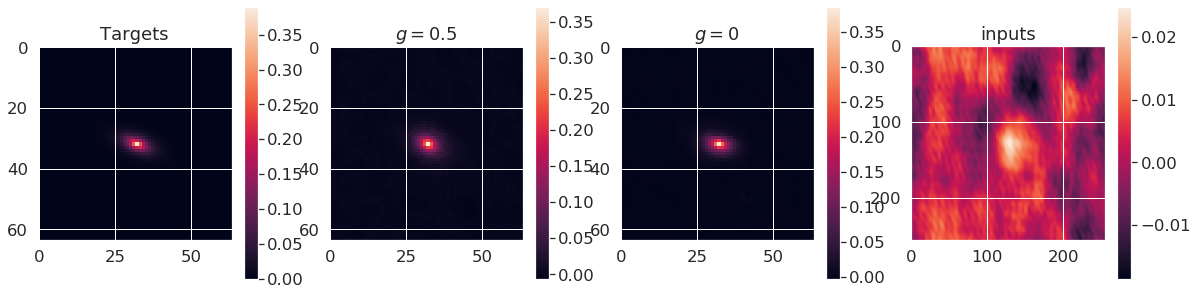

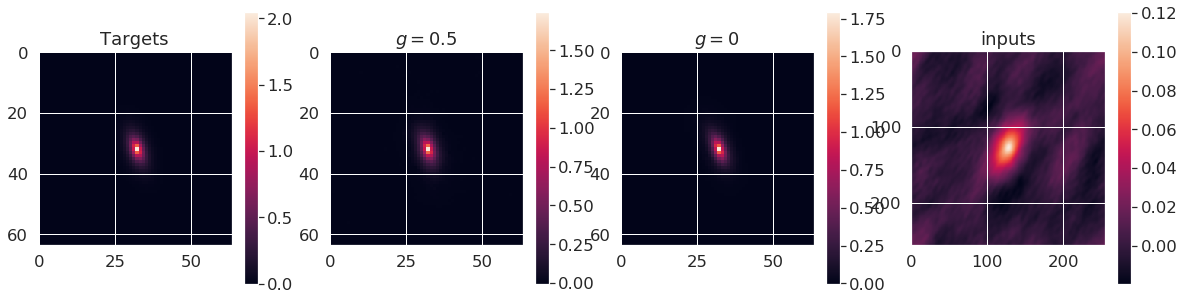

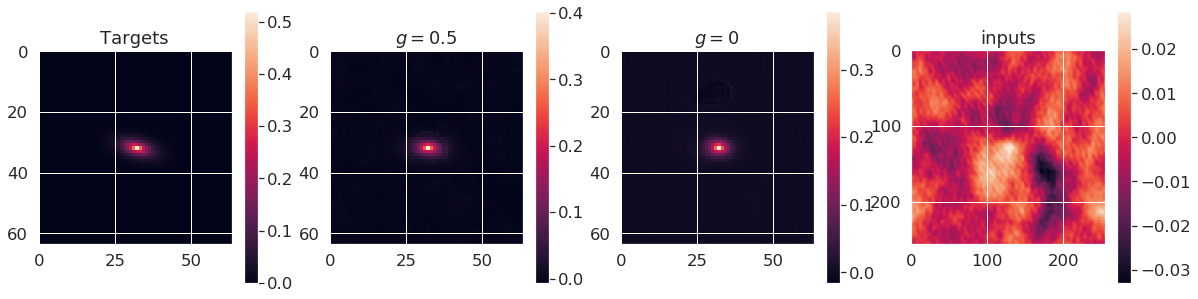

In [8]:
for i in range(5):#n_batch):
    plt.figure(33,figsize=(20,5))
    plt.subplot(141)
    plt.imshow(batch['targets'][i])
    plt.title('Targets')
    plt.colorbar()
    plt.subplot(142)
    plt.imshow(res_g05[i])
    plt.title(r'$g=0.5$')
    plt.colorbar()
    plt.subplot(143)
    plt.imshow(res_g0[i])
    plt.title(r'$g=0$')
    plt.colorbar()
    plt.subplot(144)
    plt.imshow(batch['inputs'][i])
    plt.title('inputs')
    plt.colorbar()
    plt.show()

In [9]:
U = cl.makeUi(*batch['inputs_tikho'].shape[1:3])
im_size = 64
scale = 1.5

def estimate_ell(img):
    GX = np.array([cl.scal(img,U_i) for U_i in U])
    mu20 = 0.5*(GX[3]+GX[4])-GX[0]**2/GX[2]
    mu02 = 0.5*(GX[3]-GX[4])-GX[1]**2/GX[2]
    mu11 = GX[5]-GX[0]*GX[1]/GX[2]
    e1 = (mu20-mu02)/(mu20+mu02)
    e2 = 2*(mu11)/(mu20+mu02)
    e = np.array([e1,e2])
    return e

def relative_mse(solution, ground_truth):
    relative_mse = ((solution-ground_truth)**2).mean()/ \
                         (ground_truth**2).mean()
    return relative_mse
def MSE(X1,X2,norm=False):
    #Computes the relative MSE
    temp = 1
    if norm:
        temp = np.mean(X2**2)
    return np.mean((X1-X2)**2)/temp

def MSE_obj(obj1,obj2,norm=False):
    return np.array([MSE(o1,o2,norm) for o1,o2 in zip(obj1,obj2)])

def EllipticalGaussian(e1, e2, sig, xc=im_size//2, yc=im_size//2, stamp_size=(im_size,im_size)):
    # compute centered grid
    ranges = np.array([np.arange(i) for i in stamp_size])
    x = np.outer(ranges[0] - xc, np.ones(stamp_size[1]))
    y = np.outer(np.ones(stamp_size[0]),ranges[1] - yc)
    # shift it to match centroid
    xx = (1-e1/2)*x - e2/2*y
    yy = (1+e1/2)*y - e2/2*x
    # compute elliptical gaussian
    return np.exp(-(xx ** 2 + yy ** 2) / (2 * sig ** 2))

def get_moments(images, bool_window=False):
    g_list,error_flag_list=[],[]
    if bool_window:
        window_list = []
        window_flag_list = []
    for image in images:
        error_flag = True
        #create a galsim version of the data
        image_galsim = galsim.Image(image,scale=scale)
        #estimate the moments of the observation image
        shape = galsim.hsm.FindAdaptiveMom(image_galsim
                                         ,guess_centroid=galsim.PositionD(im_size//2,im_size//2)
                                         ,strict=False)
        if bool_window:
            k_sigma = 1.2 #scale up the size of the Gaussian window to make it able to capture more useful signal
            window = EllipticalGaussian(-1.*shape.observed_shape.e1, shape.observed_shape.e2 #convention fix:
                                                                                             #e1 sign swap
                                 ,shape.moments_sigma*k_sigma # convention fix: swap x and y and origin at (0,0)
                                 ,shape.moments_centroid.y-1, shape.moments_centroid.x-1
                                 ,image.shape)
            window_flag = bool(shape.moments_status+1)
        g = np.array([shape.observed_shape.g1, shape.observed_shape.g2])
        if shape.error_message:# or np.linalg.norm(shape.corrected_g1+shape.corrected_g2*1j)>1:
            error_flag = False
        error_flag_list += [error_flag]
        g_list += [g]
        if bool_window:
            window_list += [window]
            window_flag_list += [window_flag]
    output = [np.array(g_list).T,np.array(error_flag_list)]
    if bool_window:
        output += [np.array([window_list])[0],np.array([window_flag_list])[0]]
    return output

In [10]:
# compute pixel errors
mse_g0 = np.array([MSE_obj(true,est) for true,est in zip(batch['targets'], res_g0)])
mse_g05 = np.array([MSE_obj(true,est) for true,est in zip(batch['targets'], res_g05)])

# compute relative pixel errors
mse_g0_rel = np.array([relative_mse(true,est) for true,est in zip(batch['targets'], res_g0)])
mse_g05_rel = np.array([relative_mse(true,est) for true,est in zip(batch['targets'], res_g05)])

# estimate moments
mom_g0,_ = get_moments(res_g0)
mom_g05,_ = get_moments(res_g05)
mom_true,_,windows, window_flags = get_moments(batch['targets'],bool_window=True)

# estimate ellipticities
ell_g0 = np.array([estimate_ell(gal*w) for gal,w in zip(res_g0,windows)]).T
ell_g05 = np.array([estimate_ell(gal*w) for gal,w in zip(res_g05,windows)]).T
ell_true = np.array([estimate_ell(gal*w) for gal,w in zip(batch['targets'],windows)]).T

# estimate flux
flux_g0 = np.array([gal.sum() for gal in res_g0]).T
flux_g05 = np.array([gal.sum() for gal in res_g05]).T
flux_true = np.array([gal.sum()  for gal in batch['targets']]).T

In [11]:
# compute adapative moments errors
mom_err_g0 = mom_g0-mom_true
mom_err_g05 = mom_g05-mom_true

#compute ellipticity errors
ell_err_g0 = ell_g0 - ell_true
ell_err_g05 = ell_g05 - ell_true

#compute flux relative errors
flux_err_g0 = np.abs(flux_g0 - flux_true) / flux_true
flux_err_g05 = np.abs(flux_g05 - flux_true) /flux_true

In [12]:
sigma = 7e-4

# MAKING SNR BINS
# Binning parameters
n_bins = 5
snr = np.array([np.max(gal) / sigma for gal in batch['inputs']])

# BEGIN BINNING
# Partition galaxies into bins of equal size
# Initialize lower bound
lower_bound = np.min(snr)
ind_list = []
bins = []
sqrt_num_gal = []

for i in range(n_bins-1):
    # compute quantile that is used as an upper bound
    q = np.quantile(snr,(i+1)/n_bins)
    # retrieve galaxy indices which magnitude are between the bounds
    cond = np.logical_and(lower_bound<=snr,snr<q)
    ind = np.arange(cond.size)[cond]
    sqrt_num_gal += [np.sqrt(cond.sum())]
    # retrieve corresponding objects
    snr_q = snr[ind]
    ind_list += [ind]
    print(i+1, q, np.mean(snr_q))
    bins += [np.mean(snr_q)]
    # update lower bound
    lower_bound = q
# retrieve last bin indices
cond = lower_bound<=snr
ind = np.arange(cond.size)[cond]
# retrieve corresponding objects
snr_q = snr[ind]
ind_list += [ind]
sqrt_num_gal += [np.sqrt(cond.sum())]
bins += [np.mean(snr_q)]
print(i+2, q, np.mean(snr_q))

# END BINNING

1 66.32807105779648 44.447064360778924
2 107.22619933741433 86.54270837700871
3 162.97854483127597 132.50541749316224
4 264.7628060409001 205.78692389708732
5 264.7628060409001 409.883344734172


In [13]:
# computing mean and standard deviation of relative mse error per binned SNR

mse_mean_g0 = []
mse_mean_g05 = []

mse_std_g0 = []
mse_std_g05 = []

mse_mean_g0_rel = []
mse_mean_g05_rel = []

mse_std_g0_rel = []
mse_std_g05_rel = []

# computing mean and standard deviation of adapative moments error per binned SNR

mom_mean_g0 = []
mom_mean_g05 = []

mom_median_g0 = []
mom_median_g05 = []

mom_std_g0 = []
mom_std_g05 = []

# computing mean and standard deviation of adapative moments error per binned SNR

flux_mean_g0 = []
flux_mean_g05 = []

flux_median_g0 = []
flux_median_g05 = []

flux_std_g0 = []
flux_std_g05 = []

# computing mean and standard deviation of ellipticity error per binned SNR

ell_mean_g0 = []
ell_mean_g05 = []

ell_std_g0 = []
ell_std_g05 = []

for ind in ind_list:
    
    mse_mean_g0 += [np.mean(mse_g0[ind])]
    mse_mean_g05 += [np.mean(mse_g05[ind])]

    mse_std_g0 += [np.std(mse_g0[ind])]
    mse_std_g05 += [np.std(mse_g05[ind])]
    
    mse_mean_g0_rel += [np.mean(mse_g0_rel[ind])]
    mse_mean_g05_rel += [np.mean(mse_g05_rel[ind])]

    mse_std_g0_rel += [np.std(mse_g0_rel[ind])]
    mse_std_g05_rel += [np.std(mse_g05_rel[ind])]
    
    mom_mean_g0 += [np.mean(np.abs(mom_err_g0[:,ind]),axis=1)]
    mom_mean_g05 += [np.mean(np.abs(mom_err_g05[:,ind]),axis=1)]
    
    mom_median_g0 += [np.median(np.abs(mom_err_g0[:,ind]),axis=1)]
    mom_median_g05 += [np.median(np.abs(mom_err_g05[:,ind]),axis=1)]

    mom_std_g0 += [np.std(np.abs(mom_err_g0[:,ind]),axis=1)]
    mom_std_g05 += [np.std(np.abs(mom_err_g05[:,ind]),axis=1)]
    
    ell_mean_g0 += [np.mean(np.abs(ell_err_g0[:,ind]),axis=1)]
    ell_mean_g05 += [np.mean(np.abs(ell_err_g05[:,ind]),axis=1)]

    ell_std_g0 += [np.std(np.abs(ell_err_g0[:,ind]),axis=1)]
    ell_std_g05 += [np.std(np.abs(ell_err_g05[:,ind]),axis=1)]
    
    flux_mean_g0 += [np.mean(flux_err_g0[ind])]
    flux_mean_g05 += [np.mean(flux_err_g05[ind])]

    flux_median_g0 += [np.median(flux_err_g0[ind])]
    flux_median_g05 += [np.median(flux_err_g05[ind])]

    flux_std_g0 += [np.std(flux_err_g0[ind])]
    flux_std_g05 += [np.std(flux_err_g05[ind])]
    
# Convert to numpy array with shape (2, n_bins)

mse_mean_g0 = np.array(mse_mean_g0).T
mse_mean_g05 = np.array(mse_mean_g05).T

mse_std_g0 = np.array(mse_std_g0).T
mse_std_g05 = np.array(mse_std_g05).T

mse_mean_g0_rel = np.array(mse_mean_g0_rel).T
mse_mean_g05_rel = np.array(mse_mean_g05_rel).T

mse_std_g0_rel = np.array(mse_std_g0_rel).T
mse_std_g05_rel = np.array(mse_std_g05_rel).T

mom_mean_g0 = np.array(mom_mean_g0).T
mom_mean_g05 = np.array(mom_mean_g05).T

mom_median_g0 = np.array(mom_median_g0).T
mom_median_g05 = np.array(mom_median_g05).T

mom_std_g0 = np.array(mom_std_g0).T
mom_std_g05 = np.array(mom_std_g05).T

flux_mean_g0 = np.array(flux_mean_g0).T
flux_mean_g05 = np.array(flux_mean_g05).T

flux_median_g0 = np.array(flux_median_g0).T
flux_median_g05 = np.array(flux_median_g05).T

flux_std_g0 = np.array(flux_std_g0).T
flux_std_g05 = np.array(flux_std_g05).T

ell_mean_g0 = np.array(ell_mean_g0).T
ell_mean_g05 = np.array(ell_mean_g05).T

ell_std_g0 = np.array(ell_std_g0).T
ell_std_g05 = np.array(ell_std_g05).T

/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


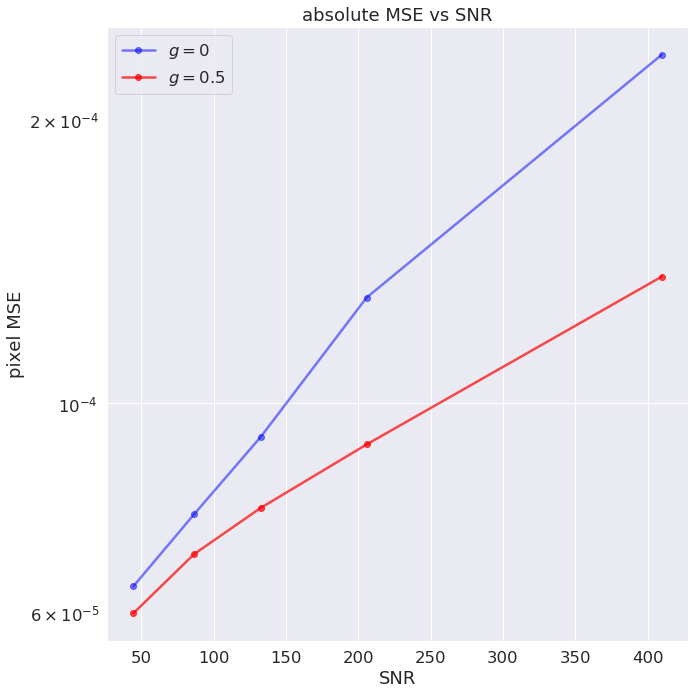

/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


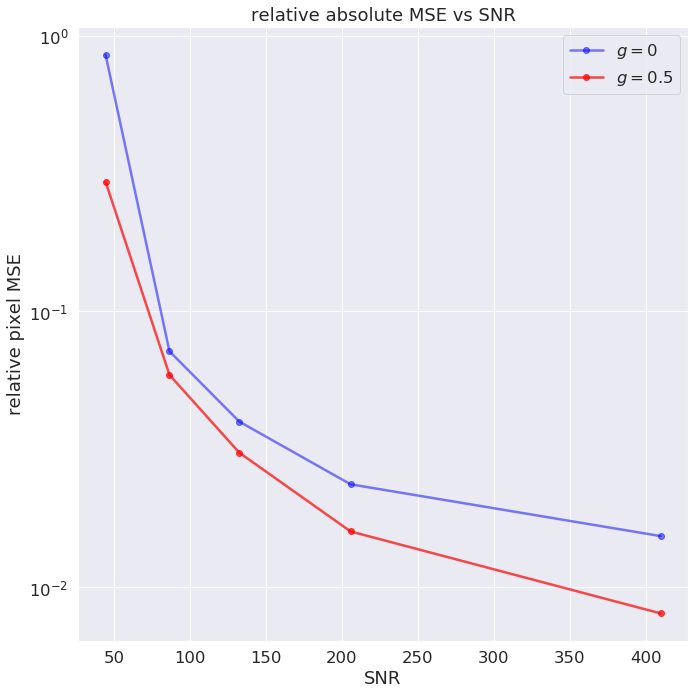

In [14]:
color_g0 = 'blue'
color_g01 = 'cyan'
color_g05 = 'red'
color_g1 = 'green'
color_g2 = 'purple'
color_g10 = 'orange'

label_g0 = r'$g=0$'
label_g01 = r'$g=0.1$'
label_g05 = r'$g=0.5$'
label_g1 = r'$g=1$'
label_g2 = r'$g=2$'
label_g10 = r'$g=10$'

plt.figure(figsize=(10,10))
# plt.errorbar(bins,mse_mean_g0,mse_std_g0/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.errorbar(bins,mse_mean_g05,mse_std_g05/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.semilogy(bins,mse_mean_g0,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.semilogy(bins,mse_mean_g05,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.ylim(bottom=0)
#plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'SNR')
plt.ylabel(r'pixel MSE')
plt.title(r'absolute MSE vs SNR')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
# plt.errorbar(bins,mse_mean_g0_rel,mse_std_g0_rel/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.errorbar(bins,mse_mean_g05_rel,mse_std_g05_rel/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.semilogy(bins,mse_mean_g0_rel,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.semilogy(bins,mse_mean_g05_rel,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.ylim(bottom=0)
#plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'SNR')
plt.ylabel(r'relative pixel MSE')
plt.title(r'relative absolute MSE vs SNR')
plt.legend()
plt.tight_layout()
plt.show()

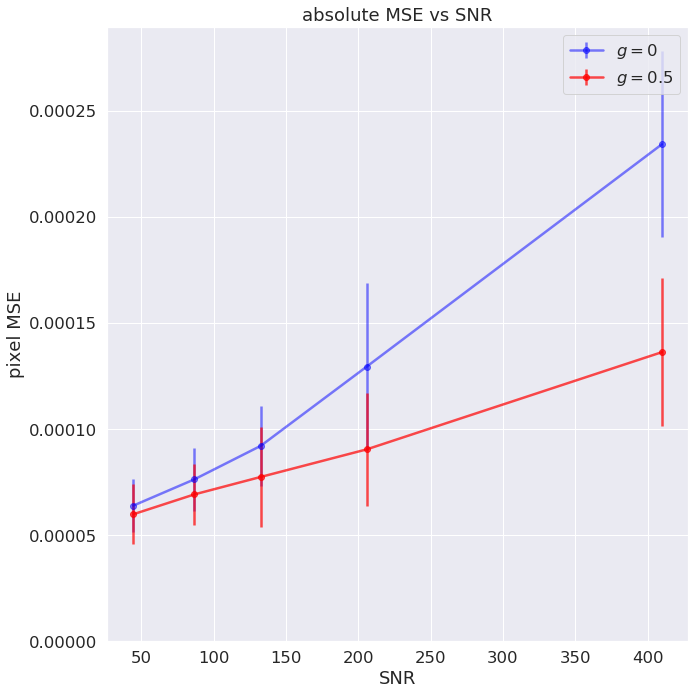

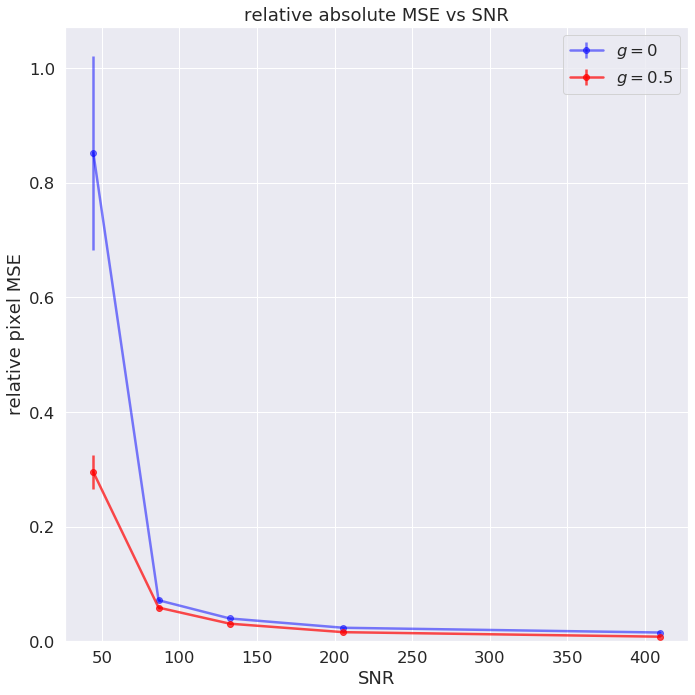

In [15]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,mse_mean_g0,mse_std_g0/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mse_mean_g05,mse_std_g05/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
# plt.semilogy(bins,mse_mean_g0,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.semilogy(bins,mse_mean_g05,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.ylim(bottom=0)
#plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'SNR')
plt.ylabel(r'pixel MSE')
plt.title(r'absolute MSE vs SNR')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.errorbar(bins,mse_mean_g0_rel,mse_std_g0_rel/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mse_mean_g05_rel,mse_std_g05_rel/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
# plt.semilogy(bins,mse_mean_g0_rel,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.semilogy(bins,mse_mean_g05_rel,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.ylim(bottom=0)
#plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'SNR')
plt.ylabel(r'relative pixel MSE')
plt.title(r'relative absolute MSE vs SNR')
plt.legend()
plt.tight_layout()
plt.show()

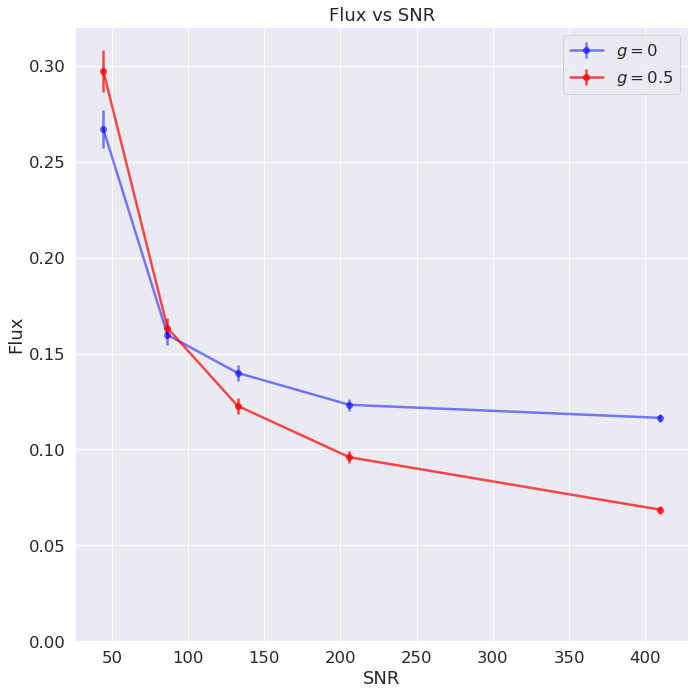

In [16]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,flux_mean_g0,flux_std_g0/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,flux_mean_g05,flux_std_g05/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
# plt.semilogy(bins,flux_mean_g0,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.semilogy(bins,flux_mean_g05,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.ylim(bottom=0)
#plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'SNR')
plt.ylabel(r'Flux')
plt.title(r'Flux vs SNR')
plt.legend()
plt.tight_layout()
plt.show()

# plt.figure(figsize=(10,10))
# plt.errorbar(bins,flux_mean_g0_rel,mse_std_g0_rel/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.errorbar(bins,flux_mean_g05_rel,mse_std_g05_rel/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
# # plt.semilogy(bins,flux_mean_g0_rel,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# # plt.semilogy(bins,flux_mean_g05_rel,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
# plt.ylim(bottom=0)
# #plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
# plt.xlabel(r'SNR')
# plt.ylabel(r'Flux')
# plt.title(r'Flux vs SNR')
# plt.legend()
# plt.tight_layout()
# plt.show()

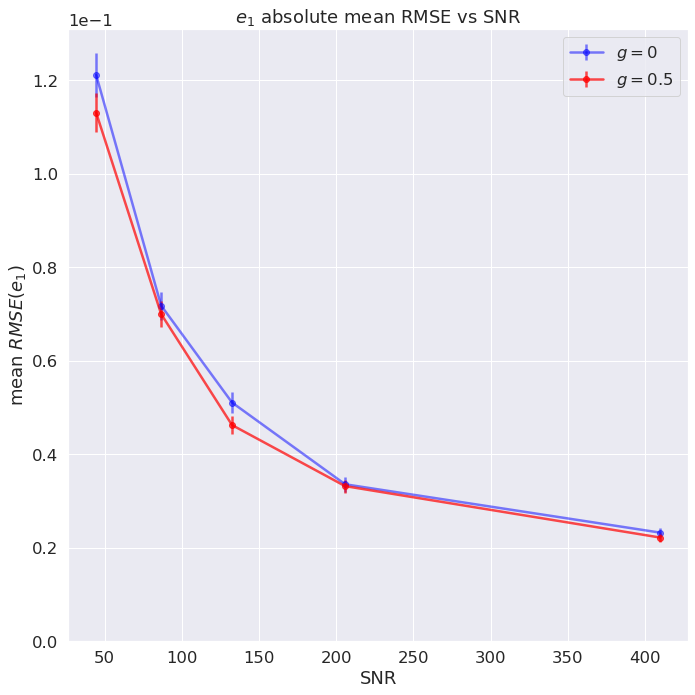

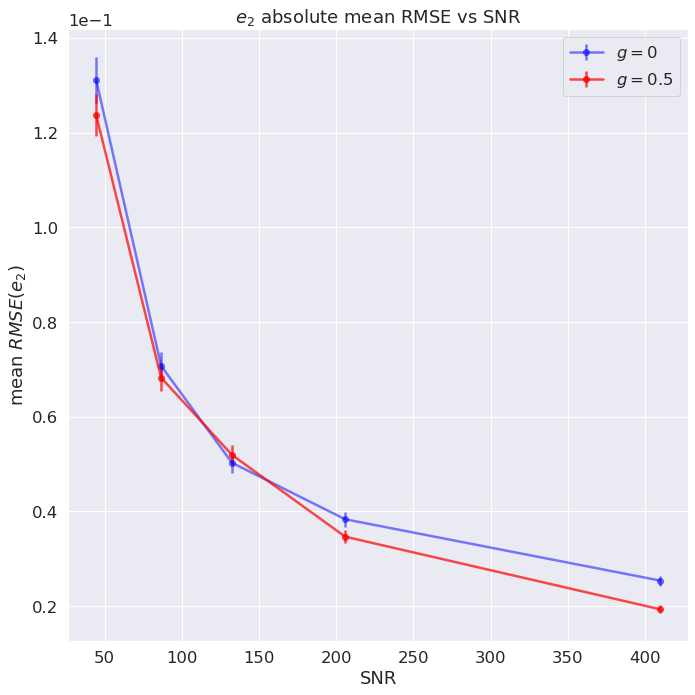

In [17]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,ell_mean_g0[0],ell_std_g0[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,ell_mean_g05[0],ell_std_g05[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.ylim(bottom=0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'SNR')
plt.ylabel(r'mean $RMSE(e_{1})$')
plt.title(r'$e_1$ absolute mean RMSE vs SNR')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.errorbar(bins,ell_mean_g0[1],ell_std_g0[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,ell_mean_g05[1],ell_std_g05[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'SNR')
plt.ylabel(r'mean $RMSE(e_2)$')
plt.title(r'$e_2$ absolute mean RMSE vs SNR')
plt.legend()
plt.tight_layout()
plt.show()

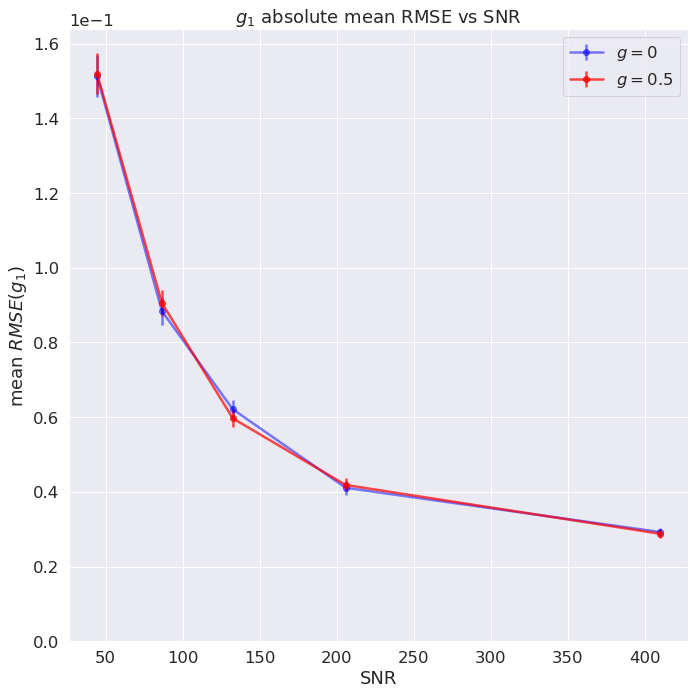

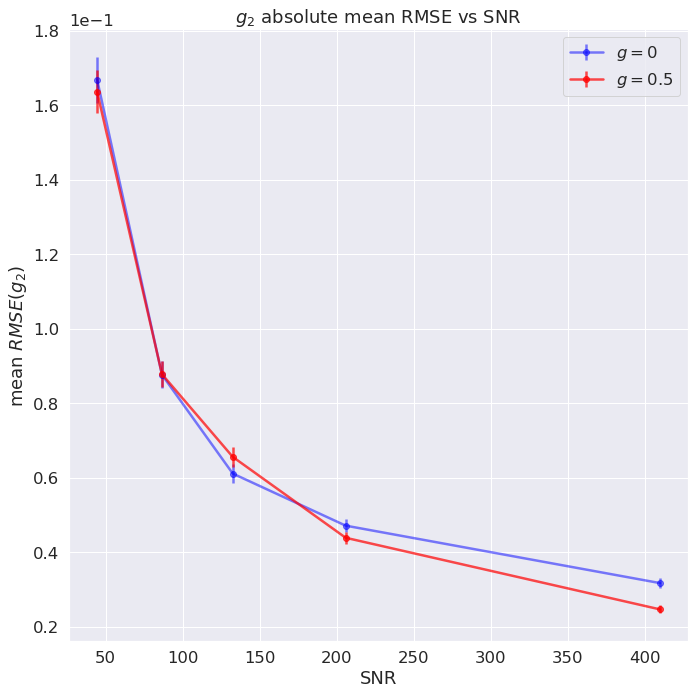

In [18]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_mean_g0[0],mom_std_g0[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mom_mean_g05[0],mom_std_g05[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.ylim(bottom=0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'SNR')
plt.ylabel(r'mean $RMSE(g_{1})$')
plt.title(r'$g_1$ absolute mean RMSE vs SNR')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_mean_g0[1],mom_std_g0[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mom_mean_g05[1],mom_std_g05[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'SNR')
plt.ylabel(r'mean $RMSE(g_2)$')
plt.title(r'$g_2$ absolute mean RMSE vs SNR')
plt.legend()
plt.tight_layout()
plt.show()

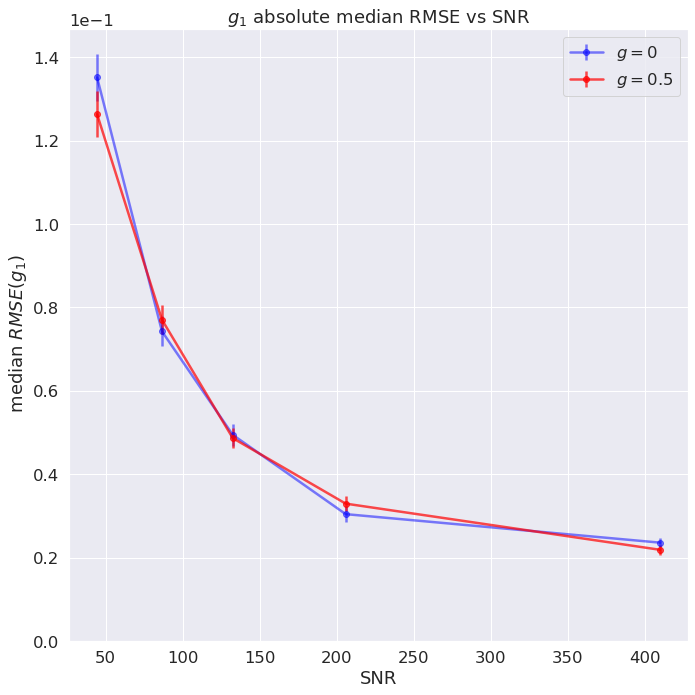

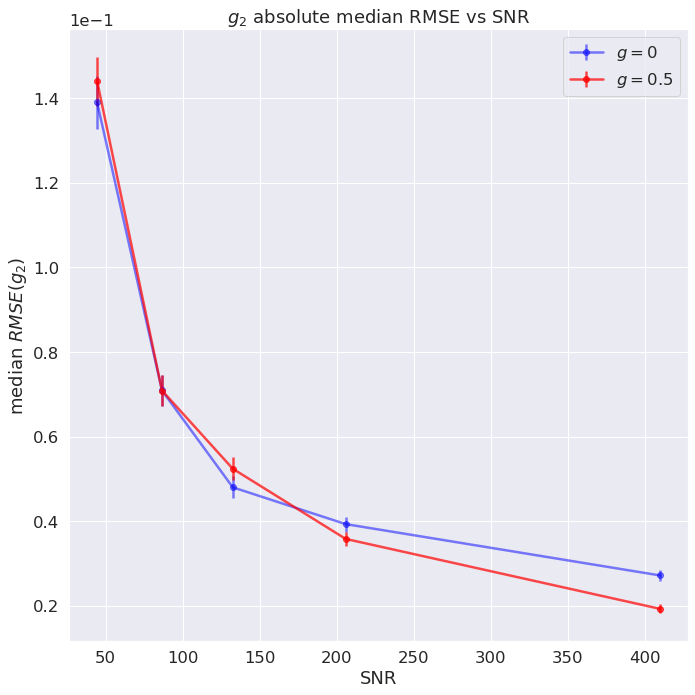

In [19]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_median_g0[0],mom_std_g0[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mom_median_g05[0],mom_std_g05[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.ylim(bottom=0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'SNR')
plt.ylabel(r' median $RMSE(g_{1})$')
plt.title(r'$g_1$ absolute median RMSE vs SNR')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_median_g0[1],mom_std_g0[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mom_median_g05[1],mom_std_g05[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'SNR')
plt.ylabel(r'median $RMSE(g_2)$')
plt.title(r'$g_2$ absolute median RMSE vs SNR')
plt.legend()
plt.tight_layout()
plt.show()

## PSF investigation

In [20]:
U_psf = cl.makeUi(256,256)

def estimate_ell_psf(img):
    GX = np.array([cl.scal(img,U_i) for U_i in U_psf])
    mu20 = 0.5*(GX[3]+GX[4])-GX[0]**2/GX[2]
    mu02 = 0.5*(GX[3]-GX[4])-GX[1]**2/GX[2]
    mu11 = GX[5]-GX[0]*GX[1]/GX[2]
    e1 = (mu20-mu02)/(mu20+mu02)
    e2 = 2*(mu11)/(mu20+mu02)
    e = np.array([e1,e2])
    return e

# estimate PSF moments
ell_psf = np.array([estimate_ell_psf(psf) for psf in batch['psf'][:,0]]).T

In [21]:
ind_psf = (np.abs(ell_psf[0])<0.3)*(np.abs(ell_psf[1])<0.3)
ind_psf.sum()

31

################### PSF 0 ####################


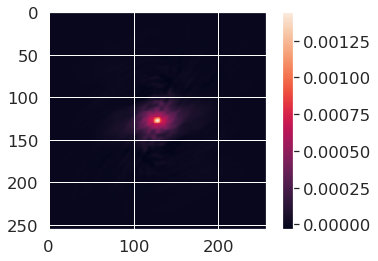

################### PSF 1 ####################


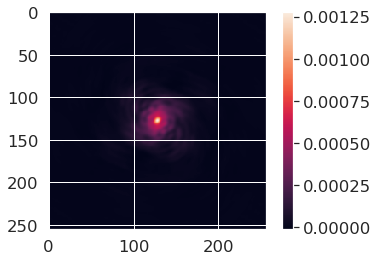

################### PSF 2 ####################


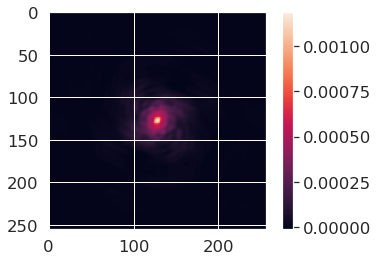

################### PSF 3 ####################


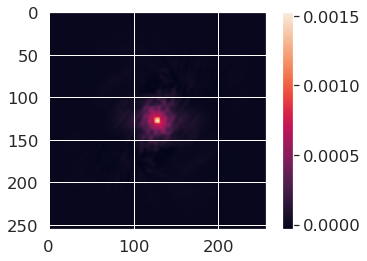

################### PSF 4 ####################


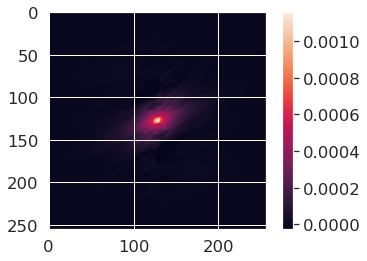

################### PSF 5 ####################


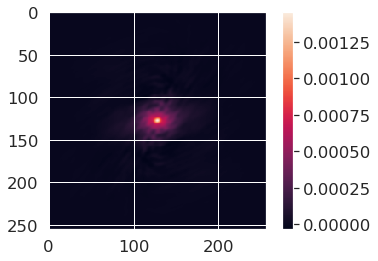

################### PSF 6 ####################


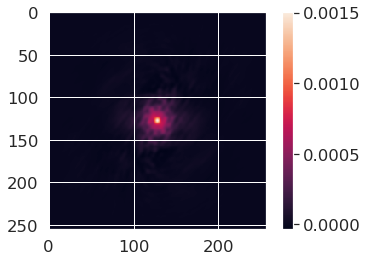

################### PSF 7 ####################


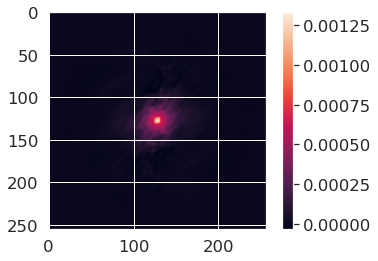

################### PSF 8 ####################


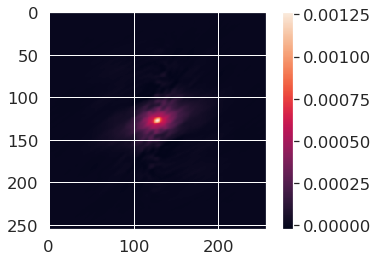

################### PSF 9 ####################


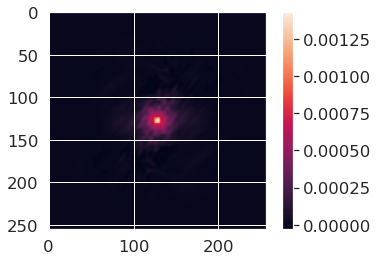

################### PSF 10 ####################


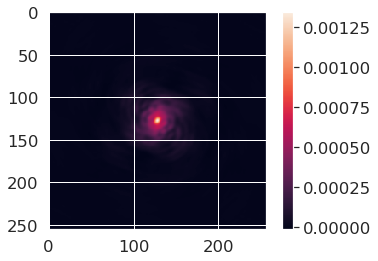

################### PSF 11 ####################


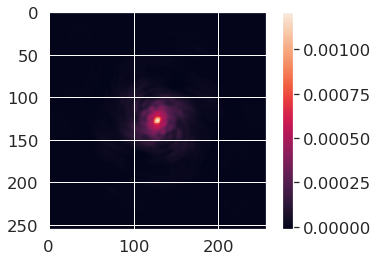

################### PSF 12 ####################


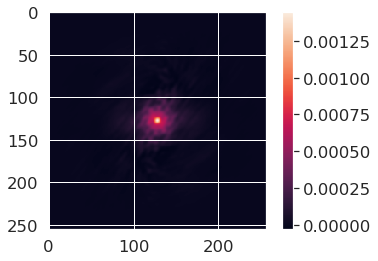

################### PSF 13 ####################


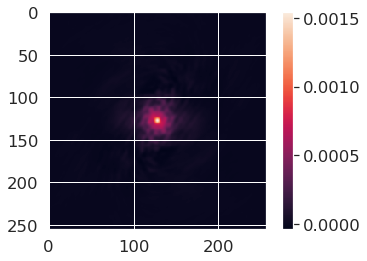

################### PSF 14 ####################


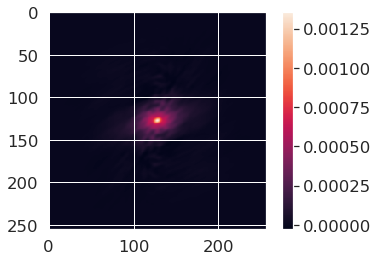

################### PSF 15 ####################


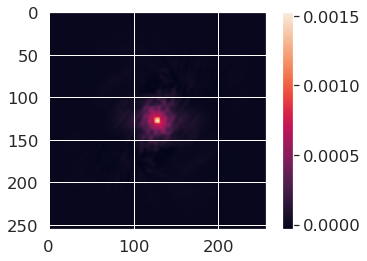

################### PSF 16 ####################


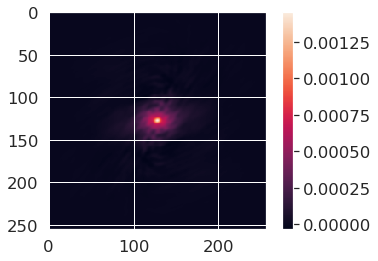

################### PSF 17 ####################


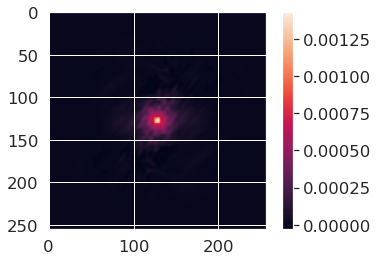

################### PSF 18 ####################


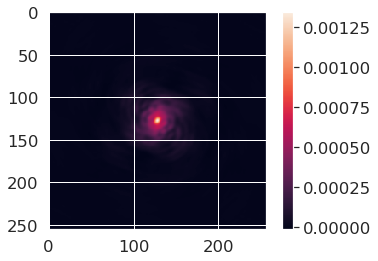

################### PSF 19 ####################


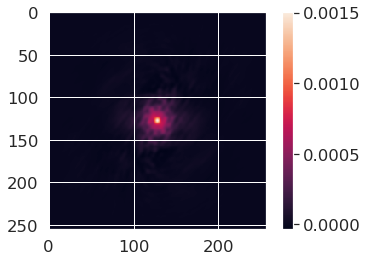

################### PSF 20 ####################


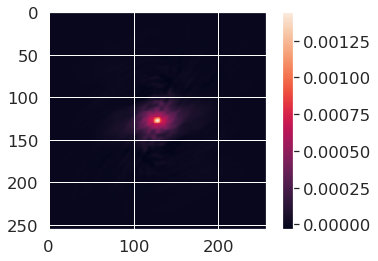

################### PSF 21 ####################


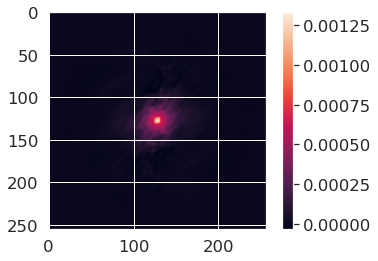

################### PSF 22 ####################


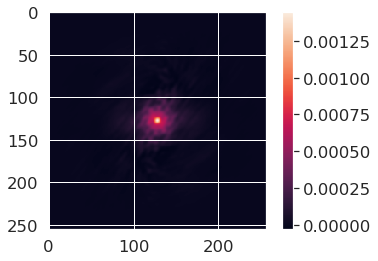

################### PSF 23 ####################


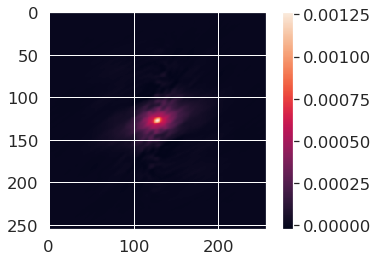

################### PSF 24 ####################


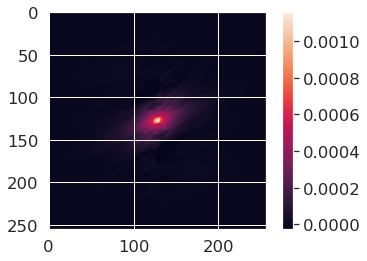

################### PSF 25 ####################


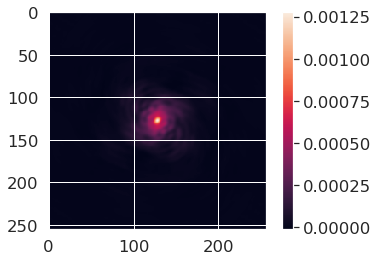

################### PSF 26 ####################


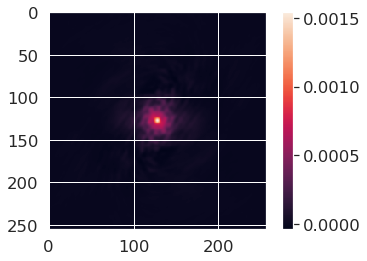

################### PSF 27 ####################


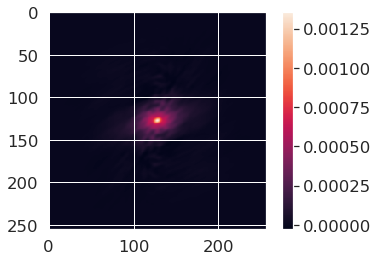

################### PSF 28 ####################


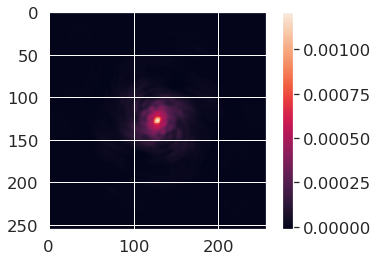

################### PSF 29 ####################


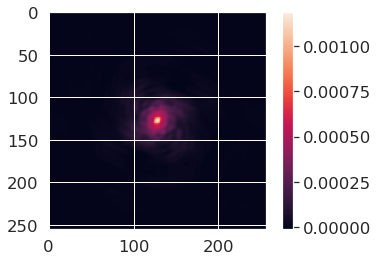

################### PSF 30 ####################


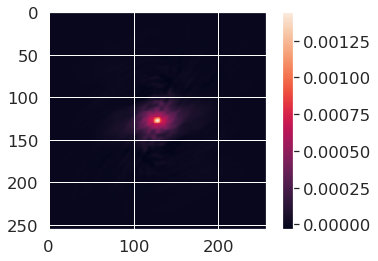

In [22]:
for i in range(ind_psf.sum()):#n_batch):
    print('################### PSF {} ####################'.format(i))
    plt.imshow(batch['psf'][ind_psf][i,0])
    plt.colorbar()
    plt.show()

################### GLAXY 0 ####################


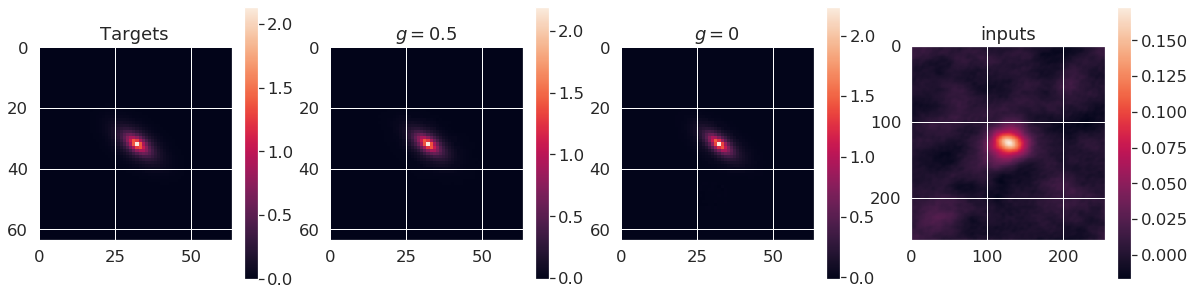

Moments of Ground Truth                       : [0.10348418 0.31683972]
Moments of Tikhonet                           : [0.10081338 0.37182031]
Moments of Tikhonet + Shape Constraint        : [0.11628572 0.3146751 ]
Relative error of Tikhonet                    : 0.16514719858414093
Relative error of Tikhonet + Shape Constraint : 0.03895237405288188
################### GLAXY 1 ####################


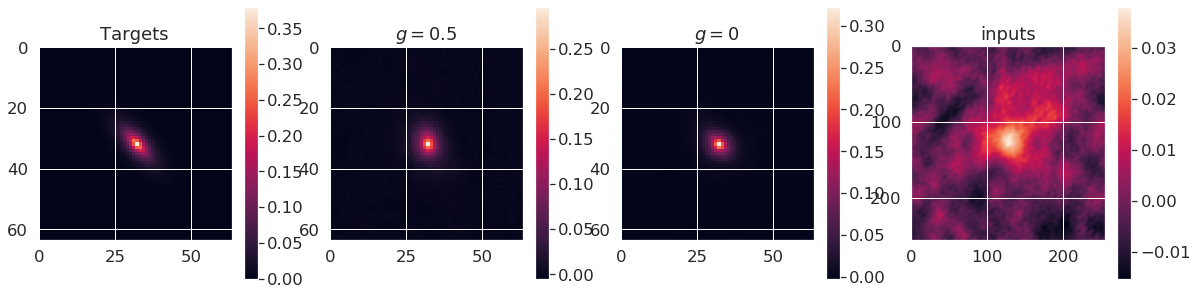

Moments of Ground Truth                       : [-0.04190818  0.37110082]
Moments of Tikhonet                           : [-0.00589412  0.12153778]
Moments of Tikhonet + Shape Constraint        : [-0.11974888  0.07296432]
Relative error of Tikhonet                    : 0.6751685466702664
Relative error of Tikhonet + Shape Constraint : 0.8250710079471576
################### GLAXY 2 ####################


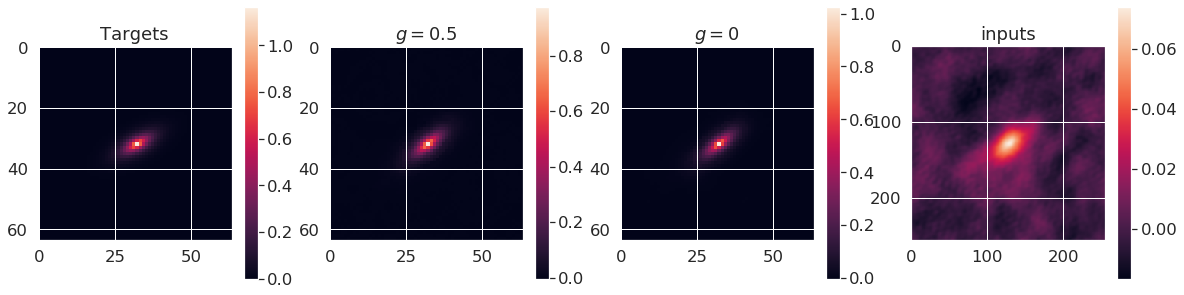

Moments of Ground Truth                       : [ 0.21897927 -0.33064477]
Moments of Tikhonet                           : [ 0.12119682 -0.43912217]
Moments of Tikhonet + Shape Constraint        : [ 0.11511873 -0.40431572]
Relative error of Tikhonet                    : 0.3682552247887463
Relative error of Tikhonet + Shape Constraint : 0.3210826977275376
################### GLAXY 3 ####################


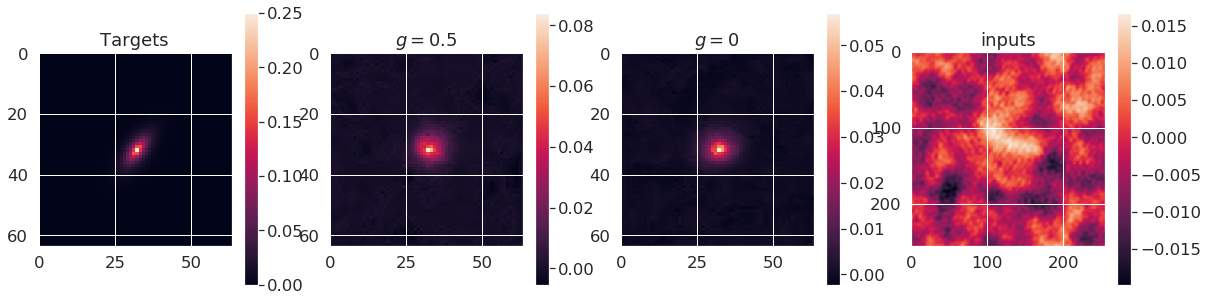

Moments of Ground Truth                       : [-0.10603829 -0.34805105]
Moments of Tikhonet                           : [ 0.07554816 -0.03430999]
Moments of Tikhonet + Shape Constraint        : [0.01971543 0.01717574]
Relative error of Tikhonet                    : 0.9963048058754805
Relative error of Tikhonet + Shape Constraint : 1.0616318498007873
################### GLAXY 4 ####################


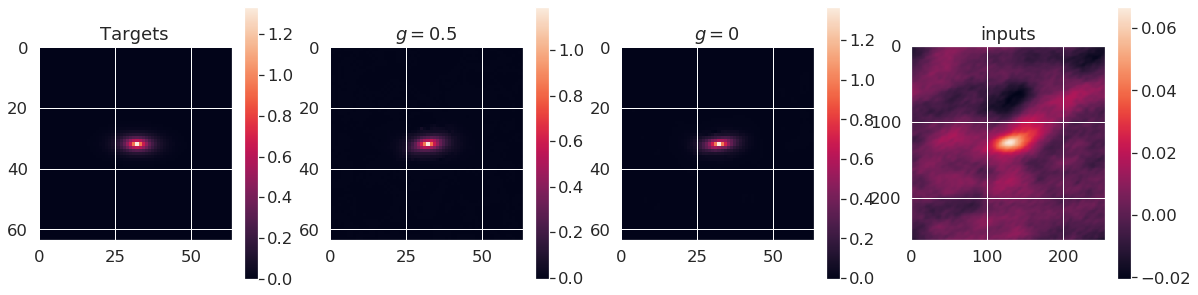

Moments of Ground Truth                       : [0.37731761 0.01396265]
Moments of Tikhonet                           : [ 0.45826005 -0.09098388]
Moments of Tikhonet + Shape Constraint        : [ 0.38853671 -0.09700501]
Relative error of Tikhonet                    : 0.35101483032778996
Relative error of Tikhonet + Shape Constraint : 0.29539323038651116
################### GLAXY 5 ####################


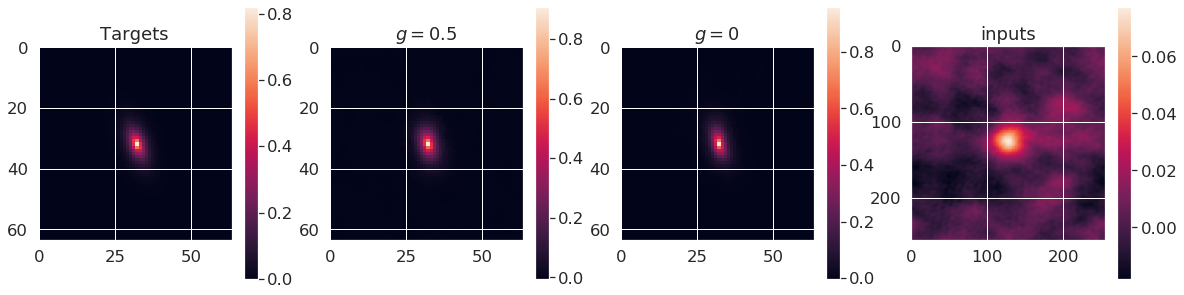

Moments of Ground Truth                       : [-0.27552689  0.20962336]
Moments of Tikhonet                           : [-0.32167084  0.16251904]
Moments of Tikhonet + Shape Constraint        : [-0.24246803  0.1127257 ]
Relative error of Tikhonet                    : 0.19046582927895034
Relative error of Tikhonet + Shape Constraint : 0.2957271970899399
################### GLAXY 6 ####################


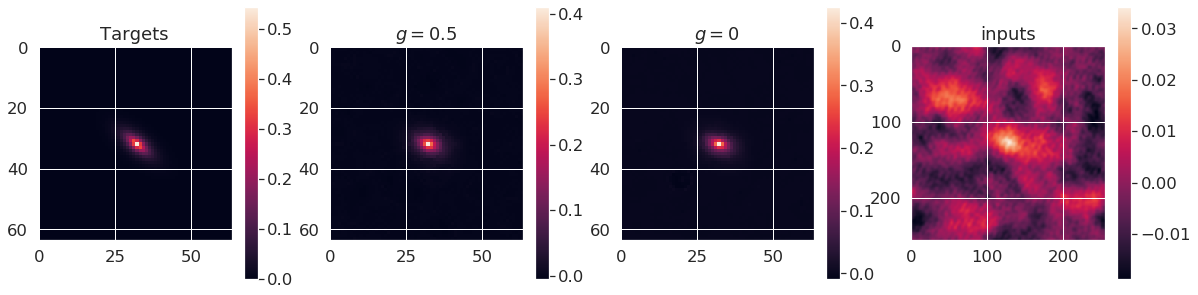

Moments of Ground Truth                       : [0.08707241 0.3743824 ]
Moments of Tikhonet                           : [0.19239139 0.12805197]
Moments of Tikhonet + Shape Constraint        : [0.1599118  0.12344846]
Relative error of Tikhonet                    : 0.696978180798954
Relative error of Tikhonet + Shape Constraint : 0.6797844341812165
################### GLAXY 7 ####################


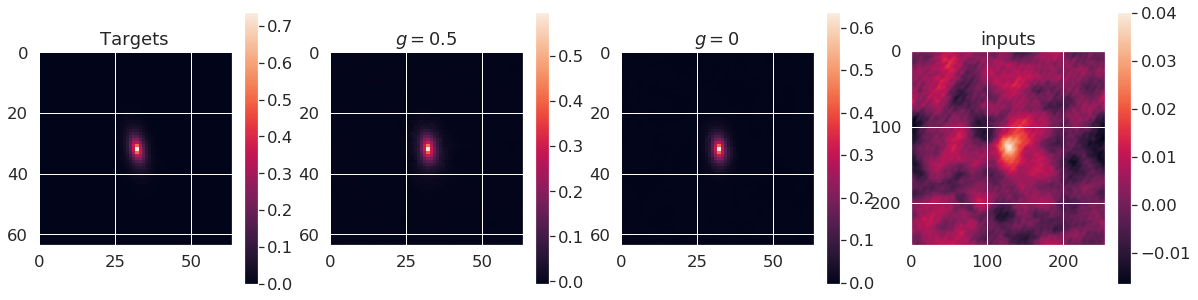

Moments of Ground Truth                       : [-0.31762119  0.14067473]
Moments of Tikhonet                           : [-0.29822343  0.05895445]
Moments of Tikhonet + Shape Constraint        : [-0.28586495  0.06553417]
Relative error of Tikhonet                    : 0.24178428896967433
Relative error of Tikhonet + Shape Constraint : 0.23483100152711464
################### GLAXY 8 ####################


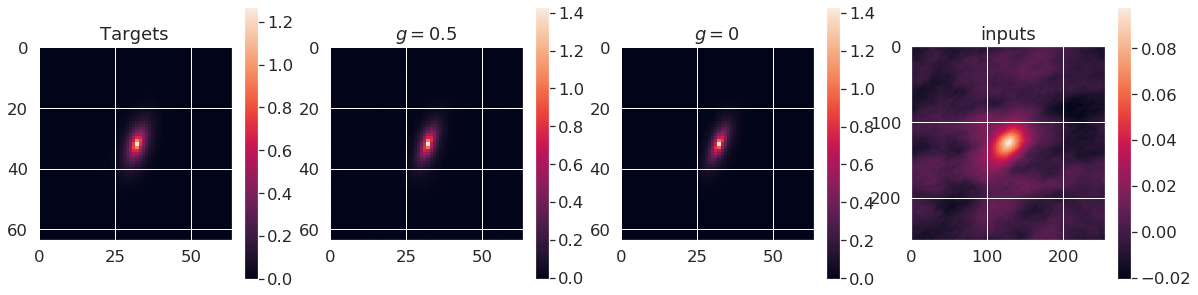

Moments of Ground Truth                       : [-0.30065446 -0.20177226]
Moments of Tikhonet                           : [-0.33751761 -0.30501174]
Moments of Tikhonet + Shape Constraint        : [-0.3393335  -0.25344527]
Relative error of Tikhonet                    : 0.3027563294570142
Relative error of Tikhonet + Shape Constraint : 0.1782618854926846
################### GLAXY 9 ####################


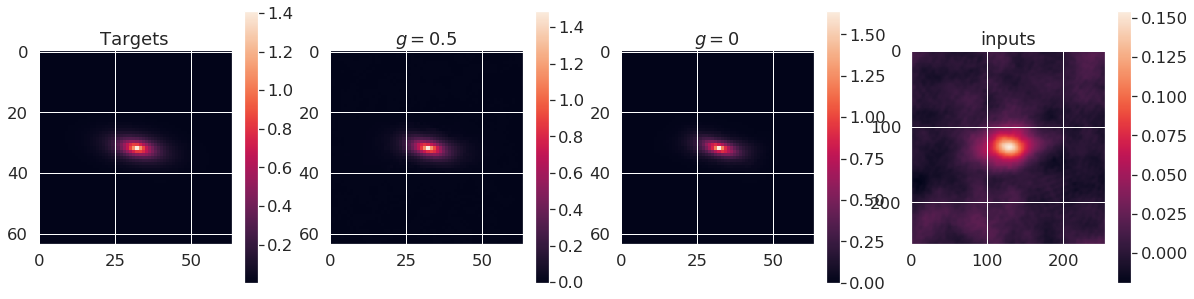

Moments of Ground Truth                       : [0.37044123 0.13901956]
Moments of Tikhonet                           : [0.41611756 0.19999829]
Moments of Tikhonet + Shape Constraint        : [0.37957406 0.16053097]
Relative error of Tikhonet                    : 0.192557397330022
Relative error of Tikhonet + Shape Constraint : 0.05906427846618254
################### GLAXY 10 ####################


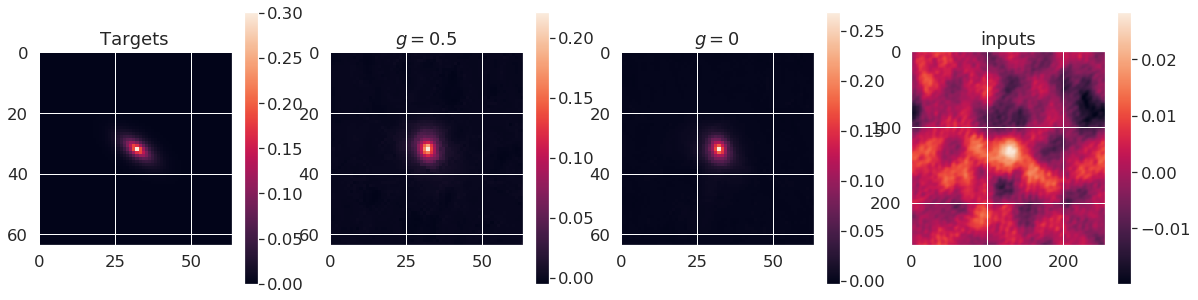

Moments of Ground Truth                       : [0.12394418 0.31954347]
Moments of Tikhonet                           : [-0.07065753  0.08349015]
Moments of Tikhonet + Shape Constraint        : [-0.06590328  0.06593281]
Relative error of Tikhonet                    : 0.8925924281468902
Relative error of Tikhonet + Shape Constraint : 0.9243094942369527
################### GLAXY 11 ####################


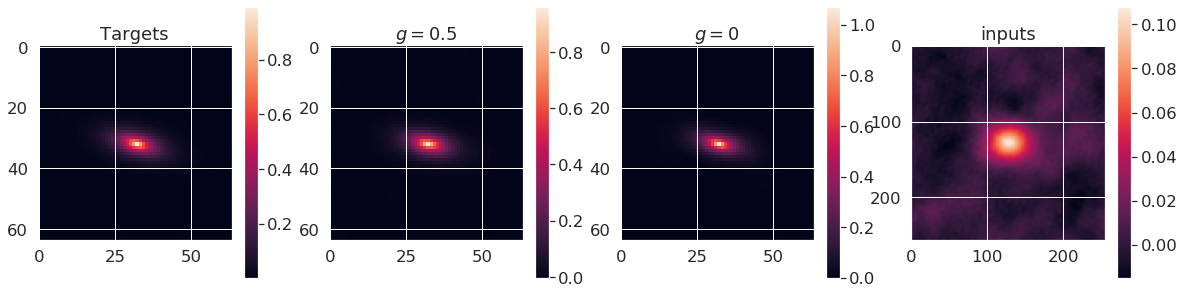

Moments of Ground Truth                       : [0.33834445 0.18850046]
Moments of Tikhonet                           : [0.36389815 0.17513146]
Moments of Tikhonet + Shape Constraint        : [0.33719407 0.14253362]
Relative error of Tikhonet                    : 0.0744611504102782
Relative error of Tikhonet + Shape Constraint : 0.11871931604027726
################### GLAXY 12 ####################


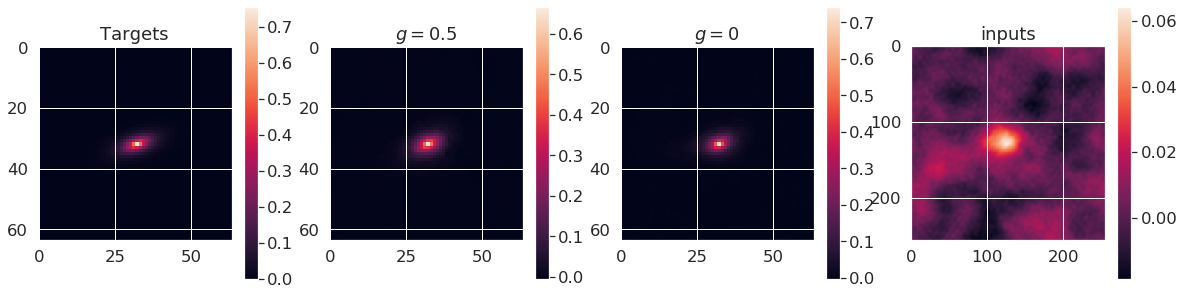

Moments of Ground Truth                       : [ 0.31577811 -0.22090968]
Moments of Tikhonet                           : [ 0.1951398  -0.13032397]
Moments of Tikhonet + Shape Constraint        : [ 0.19102315 -0.16630905]
Relative error of Tikhonet                    : 0.3914643524428629
Relative error of Tikhonet + Shape Constraint : 0.3533668802165167
################### GLAXY 13 ####################


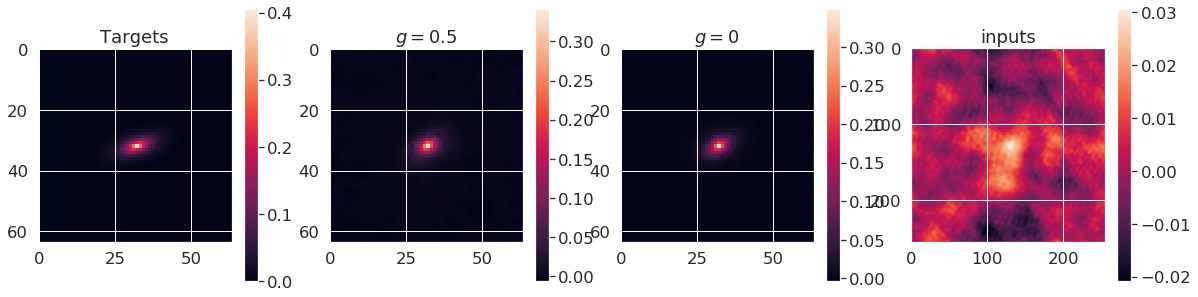

Moments of Ground Truth                       : [ 0.31702231 -0.21793094]
Moments of Tikhonet                           : [ 0.12661009 -0.18801945]
Moments of Tikhonet + Shape Constraint        : [ 0.13706682 -0.14241458]
Relative error of Tikhonet                    : 0.5010276774738741
Relative error of Tikhonet + Shape Constraint : 0.5072944908612281
################### GLAXY 14 ####################


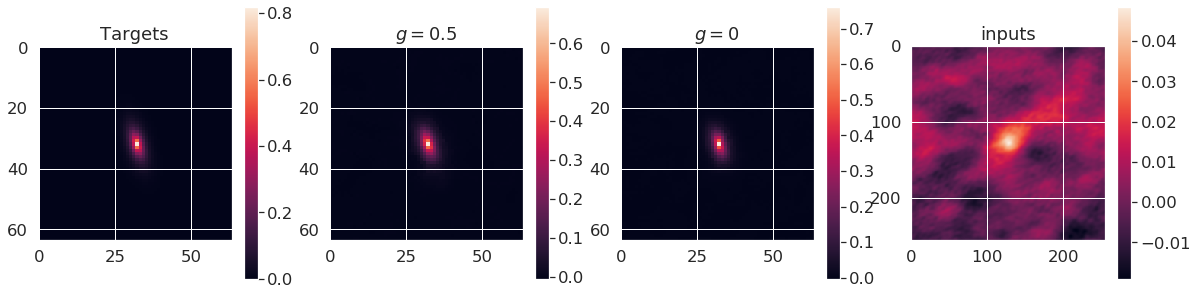

Moments of Ground Truth                       : [-0.3462004   0.20377572]
Moments of Tikhonet                           : [-0.29147908  0.17272046]
Moments of Tikhonet + Shape Constraint        : [-0.28100833  0.20006264]
Relative error of Tikhonet                    : 0.15662489024263762
Relative error of Tikhonet + Shape Constraint : 0.1625452335353417
################### GLAXY 15 ####################


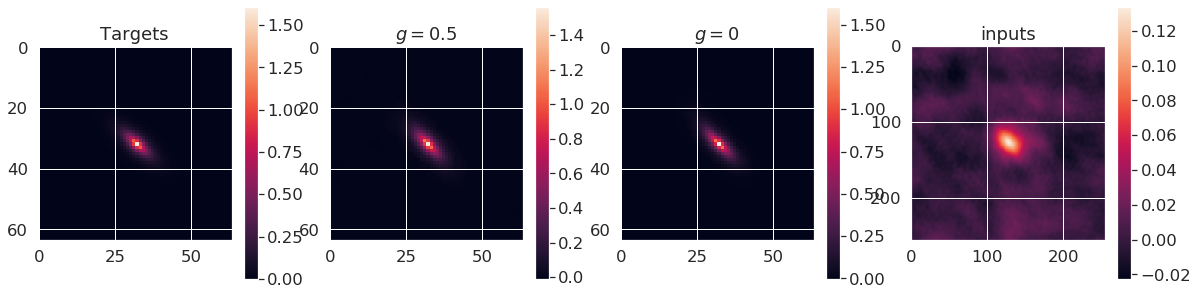

Moments of Ground Truth                       : [0.04848324 0.42814925]
Moments of Tikhonet                           : [-0.00882326  0.49772038]
Moments of Tikhonet + Shape Constraint        : [-0.01967752  0.44558222]
Relative error of Tikhonet                    : 0.20918362442785277
Relative error of Tikhonet + Shape Constraint : 0.16327953694425737
################### GLAXY 16 ####################


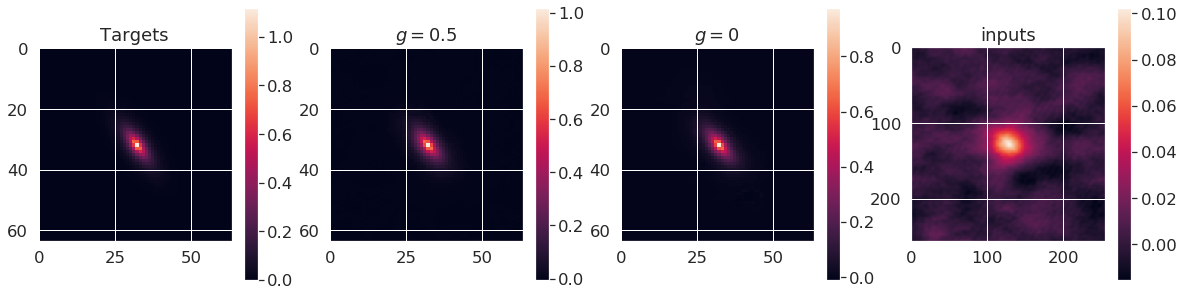

Moments of Ground Truth                       : [-0.14096009  0.39056135]
Moments of Tikhonet                           : [-0.06815609  0.3685    ]
Moments of Tikhonet + Shape Constraint        : [-0.07676199  0.33325883]
Relative error of Tikhonet                    : 0.18321156417440548
Relative error of Tikhonet + Shape Constraint : 0.20724458056876033
################### GLAXY 17 ####################


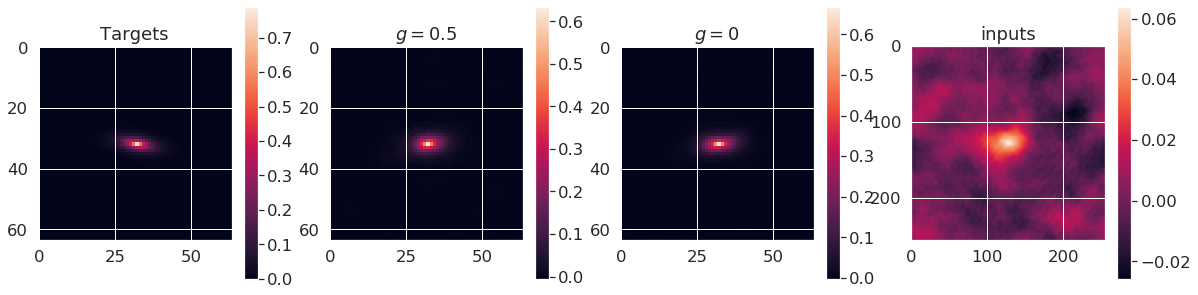

Moments of Ground Truth                       : [0.43847158 0.1535384 ]
Moments of Tikhonet                           : [ 0.36866458 -0.08380836]
Moments of Tikhonet + Shape Constraint        : [ 0.29046801 -0.06251221]
Relative error of Tikhonet                    : 0.5325268370097764
Relative error of Tikhonet + Shape Constraint : 0.5637034742812085
################### GLAXY 18 ####################


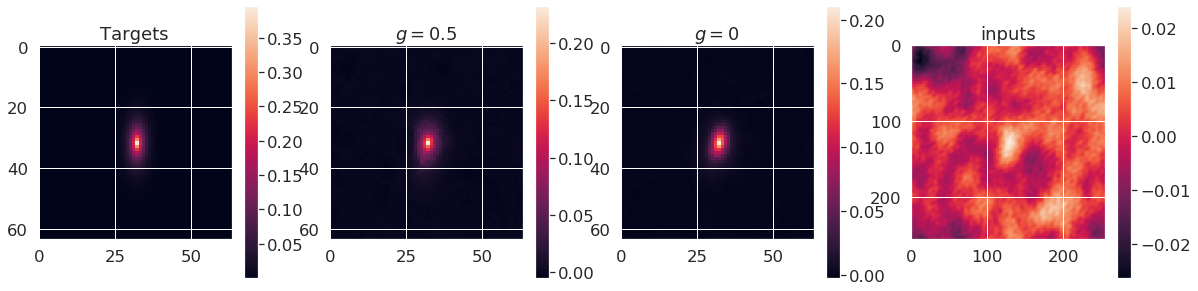

Moments of Ground Truth                       : [-0.41054977 -0.00817635]
Moments of Tikhonet                           : [-0.26809388 -0.10915249]
Moments of Tikhonet + Shape Constraint        : [-0.27037707 -0.05838444]
Relative error of Tikhonet                    : 0.4252318673652852
Relative error of Tikhonet + Shape Constraint : 0.36259638658675475
################### GLAXY 19 ####################


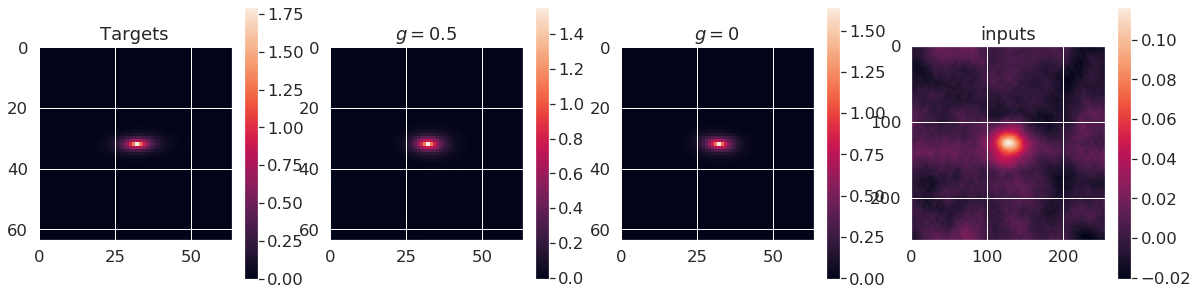

Moments of Ground Truth                       : [ 0.45349808 -0.0207881 ]
Moments of Tikhonet                           : [0.36859319 0.04751953]
Moments of Tikhonet + Shape Constraint        : [0.34069282 0.01903435]
Relative error of Tikhonet                    : 0.24003878501212547
Relative error of Tikhonet + Shape Constraint : 0.2635126943327838
################### GLAXY 20 ####################


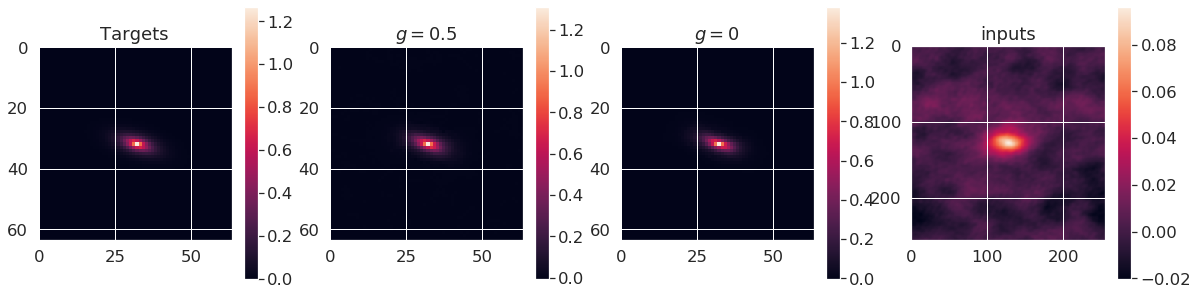

Moments of Ground Truth                       : [0.34429376 0.21473036]
Moments of Tikhonet                           : [0.39383171 0.25887407]
Moments of Tikhonet + Shape Constraint        : [0.34933007 0.23653854]
Relative error of Tikhonet                    : 0.16352379967549127
Relative error of Tikhonet + Shape Constraint : 0.055160041644630106
################### GLAXY 21 ####################


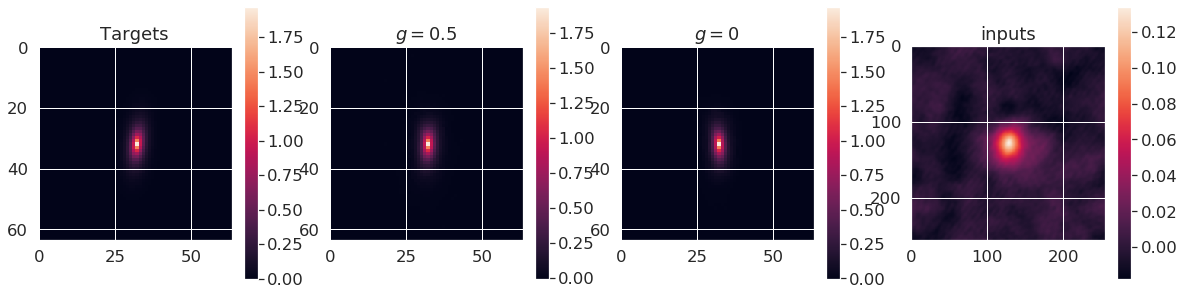

Moments of Ground Truth                       : [-0.41169607 -0.09124156]
Moments of Tikhonet                           : [-0.43080486  0.04923624]
Moments of Tikhonet + Shape Constraint        : [-0.39654057 -0.02954019]
Relative error of Tikhonet                    : 0.3362019630416061
Relative error of Tikhonet + Shape Constraint : 0.15067014200311937
################### GLAXY 22 ####################


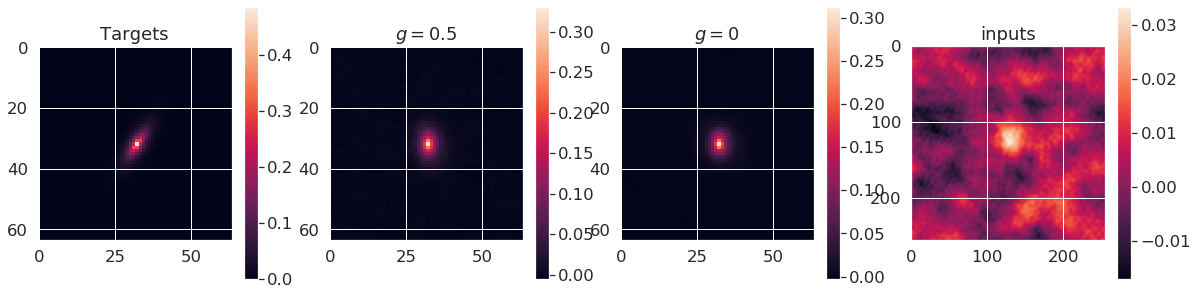

Moments of Ground Truth                       : [-0.19796948 -0.40404632]
Moments of Tikhonet                           : [-0.16452082  0.00094755]
Moments of Tikhonet + Shape Constraint        : [-0.20188458  0.02245912]
Relative error of Tikhonet                    : 0.9031725443184221
Relative error of Tikhonet + Shape Constraint : 0.9479577281951546
################### GLAXY 23 ####################


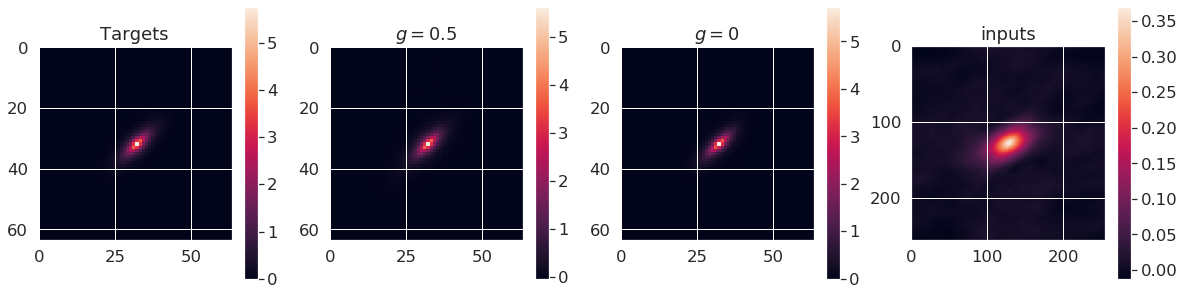

Moments of Ground Truth                       : [ 0.01824247 -0.43503232]
Moments of Tikhonet                           : [ 0.03589182 -0.47377638]
Moments of Tikhonet + Shape Constraint        : [ 0.01814959 -0.43348393]
Relative error of Tikhonet                    : 0.09777958985927696
Relative error of Tikhonet + Shape Constraint : 0.00356250854264992
################### GLAXY 24 ####################


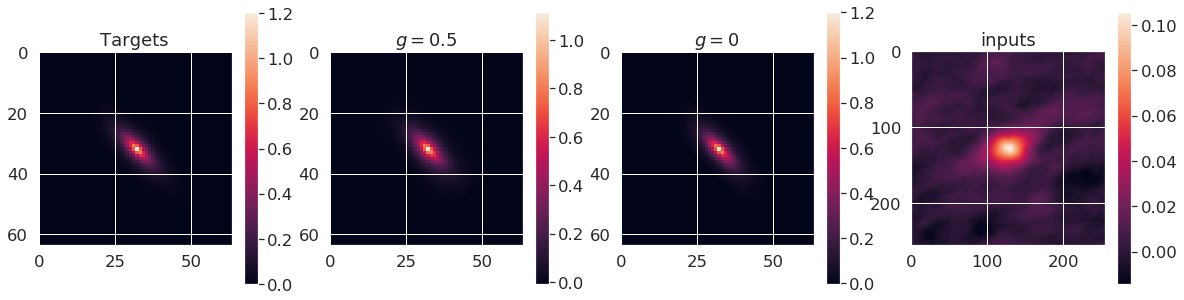

Moments of Ground Truth                       : [-0.00880358  0.44005313]
Moments of Tikhonet                           : [-0.02596801  0.4533608 ]
Moments of Tikhonet + Shape Constraint        : [-0.02321893  0.39024775]
Relative error of Tikhonet                    : 0.04934536246716509
Relative error of Tikhonet + Shape Constraint : 0.11780213519487501
################### GLAXY 25 ####################


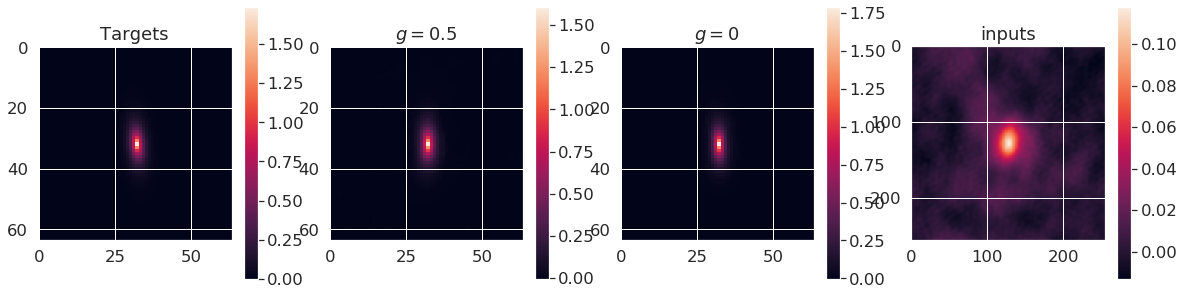

Moments of Ground Truth                       : [-0.43724698  0.07737067]
Moments of Tikhonet                           : [-0.47034081  0.02593634]
Moments of Tikhonet + Shape Constraint        : [-4.30506575e-01  2.06232743e-04]
Relative error of Tikhonet                    : 0.13773813964626064
Relative error of Tikhonet + Shape Constraint : 0.1744400056314163
################### GLAXY 26 ####################


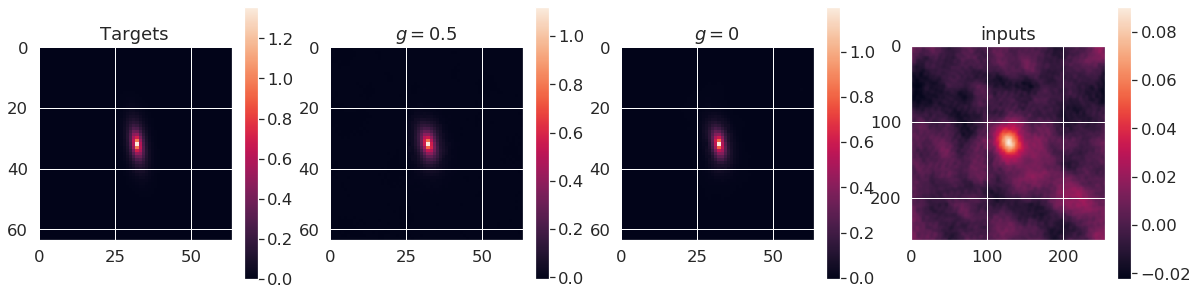

Moments of Ground Truth                       : [-0.43320556  0.13133516]
Moments of Tikhonet                           : [-0.36166249  0.13471293]
Moments of Tikhonet + Shape Constraint        : [-0.29303851  0.12456811]
Relative error of Tikhonet                    : 0.15822066611215835
Relative error of Tikhonet + Shape Constraint : 0.31000132876975717
################### GLAXY 27 ####################


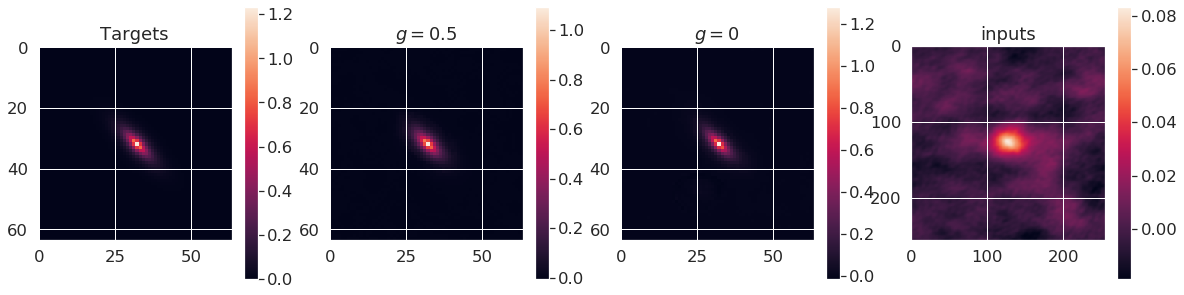

Moments of Ground Truth                       : [-0.01028891  0.47307181]
Moments of Tikhonet                           : [0.0080146  0.44428367]
Moments of Tikhonet + Shape Constraint        : [0.01891475 0.38902898]
Relative error of Tikhonet                    : 0.07209494397382873
Relative error of Tikhonet + Shape Constraint : 0.18802886166059002
################### GLAXY 28 ####################


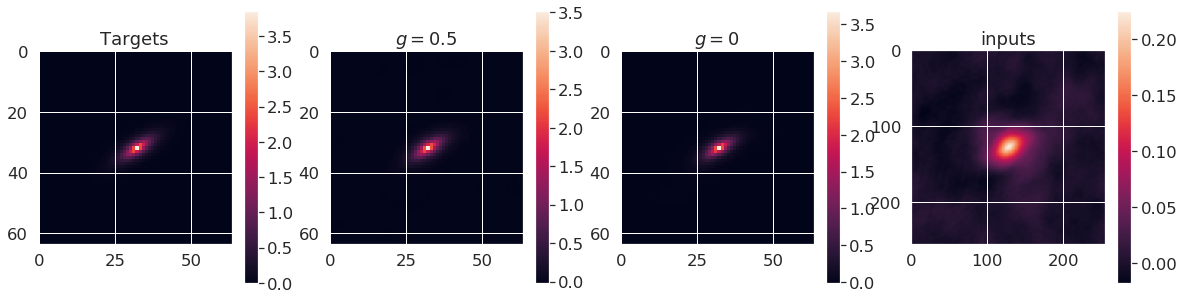

Moments of Ground Truth                       : [ 0.20291522 -0.40771317]
Moments of Tikhonet                           : [ 0.21397536 -0.37947906]
Moments of Tikhonet + Shape Constraint        : [ 0.1982678  -0.36840089]
Relative error of Tikhonet                    : 0.06658319464108811
Relative error of Tikhonet + Shape Constraint : 0.08692260602369087
################### GLAXY 29 ####################


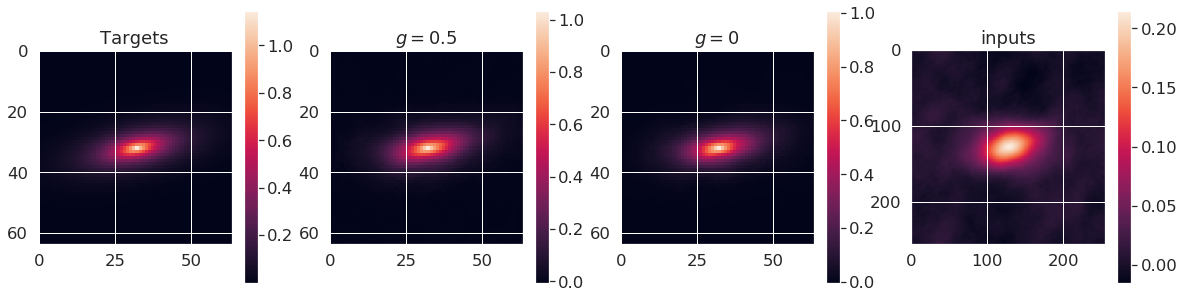

Moments of Ground Truth                       : [ 0.43198466 -0.18364246]
Moments of Tikhonet                           : [ 0.42126796 -0.15263994]
Moments of Tikhonet + Shape Constraint        : [ 0.40400405 -0.16316684]
Relative error of Tikhonet                    : 0.06988193260028677
Relative error of Tikhonet + Shape Constraint : 0.07386523223158489
################### GLAXY 30 ####################


In [ ]:
for i in range(ind_psf.sum()):#n_batch):
    print('################### GLAXY {} ####################'.format(i))
    plt.figure(33,figsize=(20,5))
    plt.subplot(141)
    plt.imshow(batch['targets'][ind_psf][i])
    plt.title('Targets')
    plt.colorbar()
    plt.subplot(142)
    plt.imshow(res_g05[ind_psf][i])
    plt.title(r'$g=0.5$')
    plt.colorbar()
    plt.subplot(143)
    plt.imshow(res_g0[ind_psf][i])
    plt.title(r'$g=0$')
    plt.colorbar()
    plt.subplot(144)
    plt.imshow(batch['inputs'][ind_psf][i])
    plt.title('inputs')
    plt.colorbar()
    plt.show()
    print('Moments of Ground Truth                       : {}'.format(mom_true[:,ind_psf][:,i]))
    print('Moments of Tikhonet                           : {}'.format(mom_g0[:,ind_psf][:,i]))
    print('Moments of Tikhonet + Shape Constraint        : {}'.format(mom_g05[:,ind_psf][:,i]))
    print('Relative error of Tikhonet                    : {}'.format(np.linalg.norm(mom_g0[:,ind_psf][:,i]-mom_true[:,ind_psf][:,i])/np.linalg.norm(mom_true[:,ind_psf][:,i])))
    print('Relative error of Tikhonet + Shape Constraint : {}'.format(np.linalg.norm(mom_g05[:,ind_psf][:,i]-mom_true[:,ind_psf][:,i])/np.linalg.norm(mom_true[:,ind_psf][:,i])))

In [ ]:
np.max(np.abs(ell_psf[0]))

In [ ]:
print(np.mean(np.abs(mom_err_g0[:,ind_psf]),axis=1))
print(np.mean(np.abs(mom_err_g05[:,ind_psf]),axis=1))

print(np.median(np.abs(mom_err_g0[:,ind_psf]),axis=1))
print(np.median(np.abs(mom_err_g05[:,ind_psf]),axis=1))

print(np.std(np.abs(mom_err_g0[:,ind_psf]),axis=1))
print(np.std(np.abs(mom_err_g05[:,ind_psf]),axis=1))

In [ ]:
print(np.mean(np.abs(mom_err_g0[:,np.logical_not(ind_psf)]),axis=1))
print(np.mean(np.abs(mom_err_g05[:,np.logical_not(ind_psf)]),axis=1))

print(np.median(np.abs(mom_err_g0[:,np.logical_not(ind_psf)]),axis=1))
print(np.median(np.abs(mom_err_g05[:,np.logical_not(ind_psf)]),axis=1))

print(np.std(np.abs(mom_err_g0[:,np.logical_not(ind_psf)]),axis=1))
print(np.std(np.abs(mom_err_g05[:,np.logical_not(ind_psf)]),axis=1))

In [ ]:
print(np.mean(np.abs(mom_err_g0[:,ind_psf])))
print(np.mean(np.abs(mom_err_g05[:,ind_psf])))

print(np.median(np.abs(mom_err_g0[:,ind_psf])))
print(np.median(np.abs(mom_err_g05[:,ind_psf])))

print(np.std(np.abs(mom_err_g0[:,ind_psf])))
print(np.std(np.abs(mom_err_g05[:,ind_psf])))